In [515]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
import re

## Part 1: EDA

In [516]:
df = pd.read_csv('./glassdoor_jobs.csv')
print(df.shape)
df.head()

(1500, 12)


Job Title  \
0                             Data Scientist   
1  2024 University Graduate - Data Scientist   
2          Data Scientist – Entry Level 2024   
3                           Data Scientist 2   
4       Entry Level Data Scientist 2023/2024   

                         Salary Estimate  \
0                                     -1   
1  Employer Provided Salary:$83K - $153K   
2  Employer Provided Salary:$71K - $133K   
3  Employer Provided Salary:$94K - $183K   
4           $48K - $78K (Glassdoor est.)   

                                     Job Description  Rating  \
0  Job Overview\nA Data Scientist at ExploreLearn...     4.2   
1  Our Company\n\nChanging the world through digi...     4.4   
2  Introduction\nRanked by Forbes as one of the w...     3.9   
3  The Microsoft 365 team is looking for a Data S...     4.3   
4  You may not realize it, but you’ve likely used...     3.9   

                  Company Name           Location                    Size  \
0  Cambium Learning Group\n4.3             Remote  1001 to 5000 Employees   
1                   Adobe\n4.4       San Jose, CA        10000+ Employees   
2                     IBM\n3.9        Atlanta, GA        10000+ Employees   
3               Microsoft\n4.3        Redmond, WA        10000+ Employees   
4                  CPChem\n3.9  The Woodlands, TX  1001 to 5000 Employees   

   Founded  Type of ownership                                 Industry  \
0     2004  Company - Private              Primary & Secondary Schools   
1     1982   Company - Public            Computer Hardware Development   
2     1911   Company - Public  Information Technology Support Services   
3     1975   Company - Public            Computer Hardware Development   
4     2000  Company - Private                   Chemical Manufacturing   

                   Sector                           Revenue  
0               Education  $500 million to $1 billion (USD)  
1  Information Technology           $5 to $10 billion (USD)  
2  Information Technology                $10+ billion (USD)  
3  Information Technology                $10+ billion (USD)  
4           Manufacturing                $10+ billion (USD)

In [517]:
# Drop duplicates revealed by EDA
df = df.drop_duplicates()

# Drop rows with missing salary estimate
df = df[df['Salary Estimate'] != '-1']

# Get state from non-remote locations
df['State'] = df['Location'].apply(lambda x: 'Remote' if x == 'Remote' else (x.split(', ')[1] if ', ' in x else '-1'))

# Fix issue where company rating appears alongside company name
def clean_company_name(name):
    if '\n' in name:
        return name.split('\n')[0].strip()
    else:
        return name.strip()

df['Company Name'] = df['Company Name'].apply(clean_company_name)

# Multiple listings from the same company --> non-iid
print(df['Company Name'].value_counts())

Company Name
-1                             9
Procter & Gamble               6
INTEL                          5
TikTok                         5
JPMorgan Chase & Co            4
                              ..
US Internal Revenue Service    1
Movable Ink                    1
LinQuest Corporation           1
AllocateRite                   1
The JAAW Group                 1
Name: count, Length: 553, dtype: int64


Job Title 0.010294117647058823
Salary Estimate 0.0
Job Description 0.008823529411764706
Rating 0.06764705882352941
Company Name 0.013235294117647059
Location 0.011764705882352941
Size 0.023529411764705882
Founded 0.17941176470588235
Type of ownership 0.023529411764705882
Industry 0.09558823529411764
Sector 0.09558823529411764
Revenue 0.023529411764705882
State 0.039705882352941174


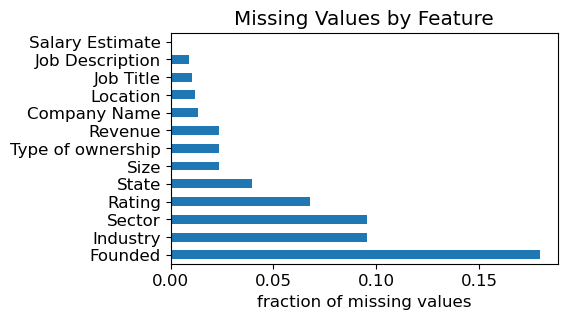

In [518]:
# Analyze missing data
missing_data = {}
for col in df.columns:
  if col in ['Rating', 'Founded']:
    num_missing = df[df[col] == -1].shape[0]
  else:
    num_missing = df[df[col] == '-1'].shape[0]
  prc_missing = num_missing / df.shape[0]
  missing_data[col] = prc_missing
  print(col, prc_missing)

plt.figure(figsize=(5,3))
series_data = pd.Series(missing_data).sort_values(ascending=False)
series_data.plot.barh()
plt.xlabel('fraction of missing values')
plt.title('Missing Values by Feature')
plt.savefig('figures/EDA/frac_missing.png', dpi=300, bbox_inches='tight')
plt.show()

In [519]:
# Reformat 'Salary Estimate' column

def transform_salary(salary_string):
    # Assume 40hr/week for 52 weeks/year
    hours_per_year = 40 * 52

    # Case 1: annual salary range
    annual_match = re.match(r'.*\$(\d+(?:\.\d+)?)[Kk] - \$(\d+(?:\.\d+)?)[Kk].*', salary_string)
    if annual_match:
        low = float(annual_match.group(1)) * 1000
        high = float(annual_match.group(2)) * 1000
        return low, high

    # Case 2: hourly rate range
    hourly_match = re.match(r'.*\$(\d+(?:\.\d+)?) - \$(\d+(?:\.\d+)?) Per Hour.*', salary_string)
    if hourly_match:
        low_salary = float(hourly_match.group(1)) * hours_per_year
        high_salary = float(hourly_match.group(2)) * hours_per_year
        return low_salary, high_salary

    # Case 3: single annual salary value
    single_annual_match = re.match(r'.*\$(\d+(?:\.\d+)?)[Kk].*', salary_string)
    if single_annual_match:
        salary_value = float(single_annual_match.group(1).replace('K', '')) * 1000
        return salary_value, salary_value

    # Case 4: single hourly rate value
    single_hourly_match = re.match(r'.*\$(\d+(?:\.\d+)?) Per Hour.*', salary_string)
    if single_hourly_match:
        hourly_rate = float(single_hourly_match.group(1))
        low_salary = hourly_rate * hours_per_year
        high_salary = hourly_rate * hours_per_year
        return low_salary, high_salary
    
    # Print any cases we missed
    print(salary_string)
    return None, None

df['Low_Salary'], df['High_Salary'] = zip(*df['Salary Estimate'].apply(transform_salary))
df['Avg_Salary'] = (df['Low_Salary'] + df['High_Salary']) / 2
df.head(2)

Job Title  \
1  2024 University Graduate - Data Scientist   
2          Data Scientist – Entry Level 2024   

                         Salary Estimate  \
1  Employer Provided Salary:$83K - $153K   
2  Employer Provided Salary:$71K - $133K   

                                     Job Description  Rating Company Name  \
1  Our Company\n\nChanging the world through digi...     4.4        Adobe   
2  Introduction\nRanked by Forbes as one of the w...     3.9          IBM   

       Location              Size  Founded Type of ownership  \
1  San Jose, CA  10000+ Employees     1982  Company - Public   
2   Atlanta, GA  10000+ Employees     1911  Company - Public   

                                  Industry                  Sector  \
1            Computer Hardware Development  Information Technology   
2  Information Technology Support Services  Information Technology   

                   Revenue State  Low_Salary  High_Salary  Avg_Salary  
1  $5 to $10 billion (USD)    CA     83000.0     153000.0    118000.0  
2       $10+ billion (USD)    GA     71000.0     133000.0    102000.0

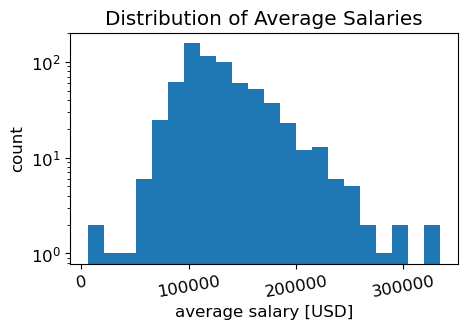

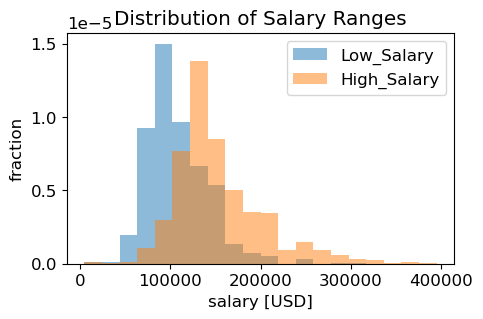

Job Title                       Salary Estimate  \
105  Data Scientist 1    Employer Provided Salary:$5K - $7K   
123   Data Specialist  Employer Provided Salary:$30K - $35K   
591    DATA SCIENTIST    Employer Provided Salary:$8K - $8K   

                                       Job Description  Rating  \
105  Requisition ID\nreq27082\n\nWorking Title\nDat...     3.8   
123  Note: While this is a fully remote position, w...     4.1   
591  DATA SCIENTIST\n\n\nReq #:\n220683\n\nDepartme...     4.2   

                 Company Name         Location               Size  Founded  \
105  University of New Mexico  Albuquerque, NM   10000+ Employees     1889   
123                  Juristat           Remote  1 to 50 Employees     2012   
591  University of Washington      Seattle, WA   10000+ Employees     1861   

        Type of ownership                                 Industry  \
105  College / University                  Colleges & Universities   
123     Company - Private  Enterprise Software & Network Solutions   
591  College / University                  Colleges & Universities   

                     Sector                   Revenue   State  Low_Salary  \
105               Education    $1 to $5 billion (USD)      NM      5000.0   
123  Information Technology  Unknown / Non-Applicable  Remote     30000.0   
591               Education    $1 to $5 billion (USD)      WA      8000.0   

     High_Salary  Avg_Salary  
105       7000.0      6000.0  
123      35000.0     32500.0  
591       8000.0      8000.0

In [520]:
# Visualize distribution of salaries
plt.figure(figsize=(5,3))
df['Avg_Salary'].plot.hist(bins=int(1+3.322*np.log(len(df)))) # Sturge's rule
plt.semilogy()
plt.xlabel('average salary [USD]')
plt.xticks(rotation=10)
plt.ylabel('count')
plt.title('Distribution of Average Salaries')
plt.show()

categories = ['Low_Salary', 'High_Salary']
bin_range = (df['Low_Salary'].min(),df['High_Salary'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df[c],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('fraction')
plt.xlabel('salary [USD]')
plt.title('Distribution of Salary Ranges')
plt.show()

# Investigate outliers
df[df['High_Salary'] < 50000]

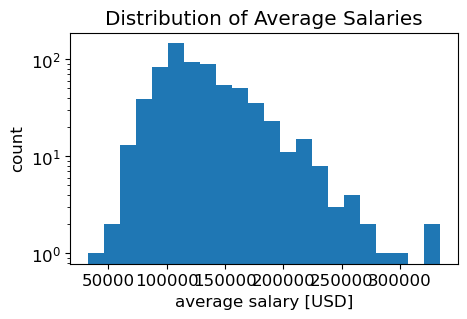

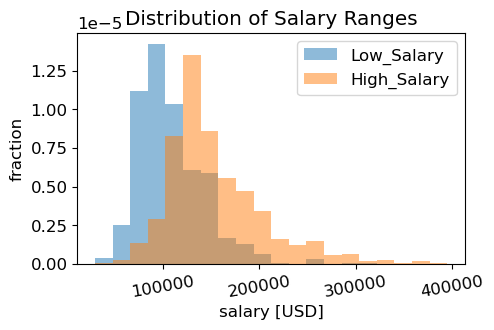

In [521]:
# The salary ranges corresponding to indices 105 and 591 are unreasonably low
# for a full-time data science position. They seem to correspond to student
# positions based on the employer name, so we will omit these from our analysis.

df.drop([105, 591], inplace=True)
df.reset_index(drop=True, inplace=True)
# Recreate histogram
plt.figure(figsize=(5,3))
df['Avg_Salary'].plot.hist(bins=int(1+3.322*np.log(len(df)))) # Sturge's rule
plt.semilogy()
plt.xlabel('average salary [USD]')
plt.ylabel('count')
plt.title('Distribution of Average Salaries')
plt.savefig('figures/EDA/target_distribution.png', dpi=300)
plt.show()

categories = ['Low_Salary', 'High_Salary']
bin_range = (df['Low_Salary'].min(),df['High_Salary'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df[c],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('fraction')
plt.xlabel('salary [USD]')
plt.xticks(rotation=10)
plt.title('Distribution of Salary Ranges')
plt.savefig('figures/EDA/high_low_salaries.png', dpi=300)
plt.show()

In [522]:
# Transform 'Job Title' column

def get_job_type(title):
  if 'engineer' in title.lower():
    return 'Data Engineer'
  elif 'data scientist' in title.lower() or 'data science' in title.lower():
    return 'Data Scientist'
  elif 'analyst' in title.lower() or 'analytics' in title.lower():
    return 'Data Analyst'
  else:
    # print(title)
    return 'Other'

def get_level(title):
  if 'Entry Level' in title or 'College Graduate' in title:
    return 'Entry Level'
  elif 'Junior' in title or 'Jr. ' in title or 'Jr ' in title:
    return 'Junior'
  elif 'Senior' in title or 'Sr. ' in title or 'Sr ' in title:
    return 'Senior'
  elif 'Lead ' in title or 'Chief ' in title or 'Principal' in title:
    return 'Very Senior'
  else:
    return 'Unspecified'

df['Job Type'] = df['Job Title'].apply(get_job_type)
df['Experience Level'] = df['Job Title'].apply(get_level)
df.head(2)

Job Title  \
0  2024 University Graduate - Data Scientist   
1          Data Scientist – Entry Level 2024   

                         Salary Estimate  \
0  Employer Provided Salary:$83K - $153K   
1  Employer Provided Salary:$71K - $133K   

                                     Job Description  Rating Company Name  \
0  Our Company\n\nChanging the world through digi...     4.4        Adobe   
1  Introduction\nRanked by Forbes as one of the w...     3.9          IBM   

       Location              Size  Founded Type of ownership  \
0  San Jose, CA  10000+ Employees     1982  Company - Public   
1   Atlanta, GA  10000+ Employees     1911  Company - Public   

                                  Industry                  Sector  \
0            Computer Hardware Development  Information Technology   
1  Information Technology Support Services  Information Technology   

                   Revenue State  Low_Salary  High_Salary  Avg_Salary  \
0  $5 to $10 billion (USD)    CA     83000.0     153000.0    118000.0   
1       $10+ billion (USD)    GA     71000.0     133000.0    102000.0   

         Job Type Experience Level  
0  Data Scientist      Unspecified  
1  Data Scientist      Entry Level

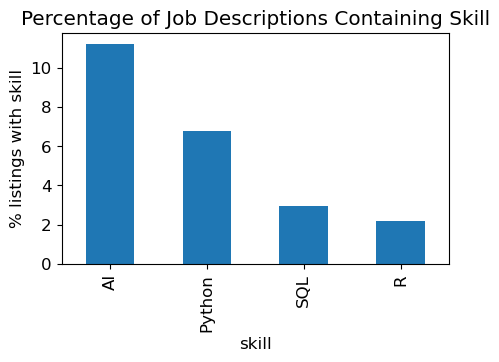

Job Title  \
0  2024 University Graduate - Data Scientist   
1          Data Scientist – Entry Level 2024   

                         Salary Estimate  \
0  Employer Provided Salary:$83K - $153K   
1  Employer Provided Salary:$71K - $133K   

                                     Job Description  Rating Company Name  \
0  Our Company\n\nChanging the world through digi...     4.4        Adobe   
1  Introduction\nRanked by Forbes as one of the w...     3.9          IBM   

       Location              Size  Founded Type of ownership  \
0  San Jose, CA  10000+ Employees     1982  Company - Public   
1   Atlanta, GA  10000+ Employees     1911  Company - Public   

                                  Industry  ... State Low_Salary High_Salary  \
0            Computer Hardware Development  ...    CA    83000.0    153000.0   
1  Information Technology Support Services  ...    GA    71000.0    133000.0   

   Avg_Salary        Job Type  Experience Level Python  R  SQL  AI  
0    118000.0  Data Scientist       Unspecified      1  1    1   0  
1    102000.0  Data Scientist       Entry Level      0  0    0   1  

[2 rows x 22 columns]

In [523]:
# Transform 'Job Description' column
df['Job Description'] = df['Job Description'].str.replace(r'\n', ' ')

# Create new columns using 'Job Description' column
skills_mapping = {
        "Python": ["python", "tensorflow", "pytorch", "pandas"],
        "R": ["r", "rstudio"],
        "SQL": ["sql", "postgresql", "mysql", "nosql"],
        "AI": ["ai", "artificial intelligence", "ml", "machine learning",
                                     "deep learning", "nlp", "natural language processing"],
    }

def create_skill_columns(df):
    for skill, aliases in skills_mapping.items():
        df[skill] = df['Job Description'].apply(lambda x: 1 if any(alias.lower() in x.lower().split() for alias in aliases) else 0)
    return df
df_skills = create_skill_columns(df)
percentages = df_skills[skills_mapping.keys()].mean() * 100
percentages_sorted = percentages.sort_values(ascending=False)

plt.figure(figsize=(5, 3))
percentages_sorted.plot.bar()
plt.ylabel('% listings with skill')
plt.xlabel('skill')
plt.title('Percentage of Job Descriptions Containing Skill')
plt.savefig('figures/EDA/keywords_appearances.png', dpi=300, bbox_inches='tight')
plt.show()

df.head(2)

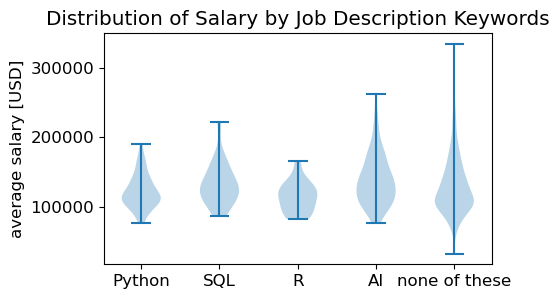

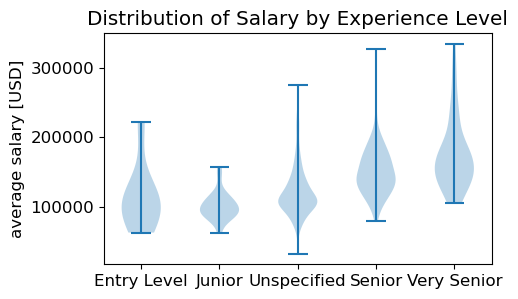

In [524]:
plt.figure(figsize=(5,3))
plt.violinplot([df[df['Python']==1]['Avg_Salary'].values,
                df[df['SQL']==1]['Avg_Salary'].values,
                df[df['R']==1]['Avg_Salary'].values,
                df[df['AI']==1]['Avg_Salary'].values,
                df[(df['Python']==0) & (df['R']==0) & (df['SQL']==0) & (df['AI']==0)]['Avg_Salary'].values])
plt.xticks([1,2,3,4,5],['Python', 'SQL', 'R', 'AI', 'none of these'])
plt.ylabel('average salary [USD]')
plt.title('Distribution of Salary by Job Description Keywords')
plt.savefig('salary_vs_keywords.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(5,3))
plt.violinplot([df[df['Experience Level']=='Entry Level']['Avg_Salary'].values,
                df[df['Experience Level']=='Junior']['Avg_Salary'].values,
                df[df['Experience Level']=='Unspecified']['Avg_Salary'].values,
                df[df['Experience Level']=='Senior']['Avg_Salary'].values,
                df[df['Experience Level']=='Very Senior']['Avg_Salary'].values
            ])
plt.xticks([1,2,3,4,5],['Entry Level','Junior','Unspecified','Senior','Very Senior'])
plt.ylabel('average salary [USD]')
plt.title('Distribution of Salary by Experience Level')
plt.savefig('figures/EDA/salary_vs_exp.png', dpi=300, bbox_inches='tight')
plt.show()

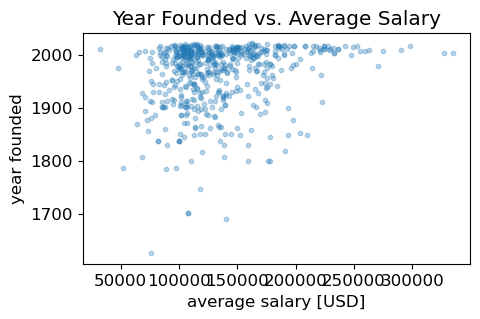

            Avg_Salary  Founded
Avg_Salary     1.00000  0.16503
Founded        0.16503  1.00000


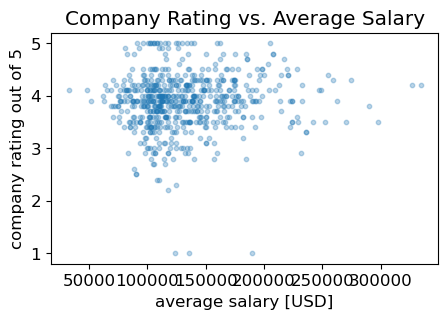

            Avg_Salary    Rating
Avg_Salary    1.000000  0.070715
Rating        0.070715  1.000000


In [525]:
# Compare continuous features to target

# plt.figure(figsize=(5,3))
df[df['Founded'] != -1].plot.scatter('Avg_Salary','Founded',figsize=(5,3),alpha=0.3,s=10)
plt.xlabel('average salary [USD]')
plt.ylabel('year founded')
plt.title('Year Founded vs. Average Salary')
plt.savefig('figures/EDA/salary_vs_year.png', dpi=300, bbox_inches='tight')
plt.show()
print(df[['Avg_Salary', 'Founded']].corr())

# plt.figure(figsize=(5,3))
df[df['Rating'] != -1].plot.scatter('Avg_Salary','Rating',figsize=(5,3),alpha=0.3,s=10)
plt.xlabel('average salary [USD]')
plt.ylabel('company rating out of 5')
plt.title('Company Rating vs. Average Salary')
plt.savefig('figures/EDA/salary_vs_rating.png', dpi=300, bbox_inches='tight')
plt.show()
print(df[['Avg_Salary', 'Rating']].corr())

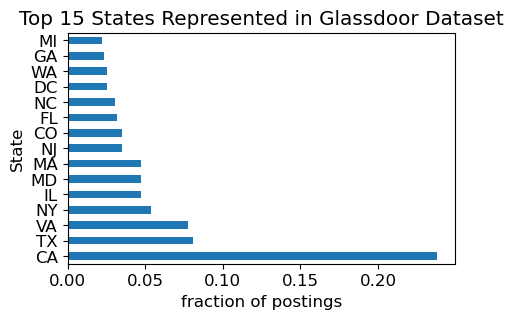

In [526]:
plt.figure(figsize=(5,3))
pd.value_counts(df[(df['State'] != '-1') & (df['State'] != 'Remote')]['State'],normalize=True).nlargest(15).plot.barh()
plt.xlabel('fraction of postings')
plt.title('Top 15 States Represented in Glassdoor Dataset')
plt.savefig('figures/EDA/top_states.png',dpi=300,bbox_inches='tight')
plt.show()

In [527]:
# Group "Unknown" and missing values together in the same category

df['Size'] = df['Size'].replace('Unknown', '-1')
df['Type of ownership'] = df['Type of ownership'].replace('Unknown', '-1')
df['Revenue'] = df['Revenue'].replace('Unknown / Non-Applicable', '-1')

ftrs = ['Size', 'Type of ownership', 'Revenue']
for ftr in ftrs:
  print(df[ftr].value_counts())
  print('')

Size
10000+ Employees           237
1001 to 5000 Employees     118
1 to 50 Employees           71
51 to 200 Employees         68
-1                          55
201 to 500 Employees        44
5001 to 10000 Employees     43
501 to 1000 Employees       42
Name: count, dtype: int64

Type of ownership
Company - Private                 275
Company - Public                  263
Nonprofit Organization             37
Subsidiary or Business Segment     26
Government                         21
-1                                 18
College / University               16
Hospital                            8
Self-employed                       6
Private Practice / Firm             4
Contract                            4
Name: count, dtype: int64

Revenue
-1                                  259
$10+ billion (USD)                  153
$1 to $5 billion (USD)               69
$100 to $500 million (USD)           51
$5 to $25 million (USD)              35
$5 to $10 billion (USD)              33
$25 to $1

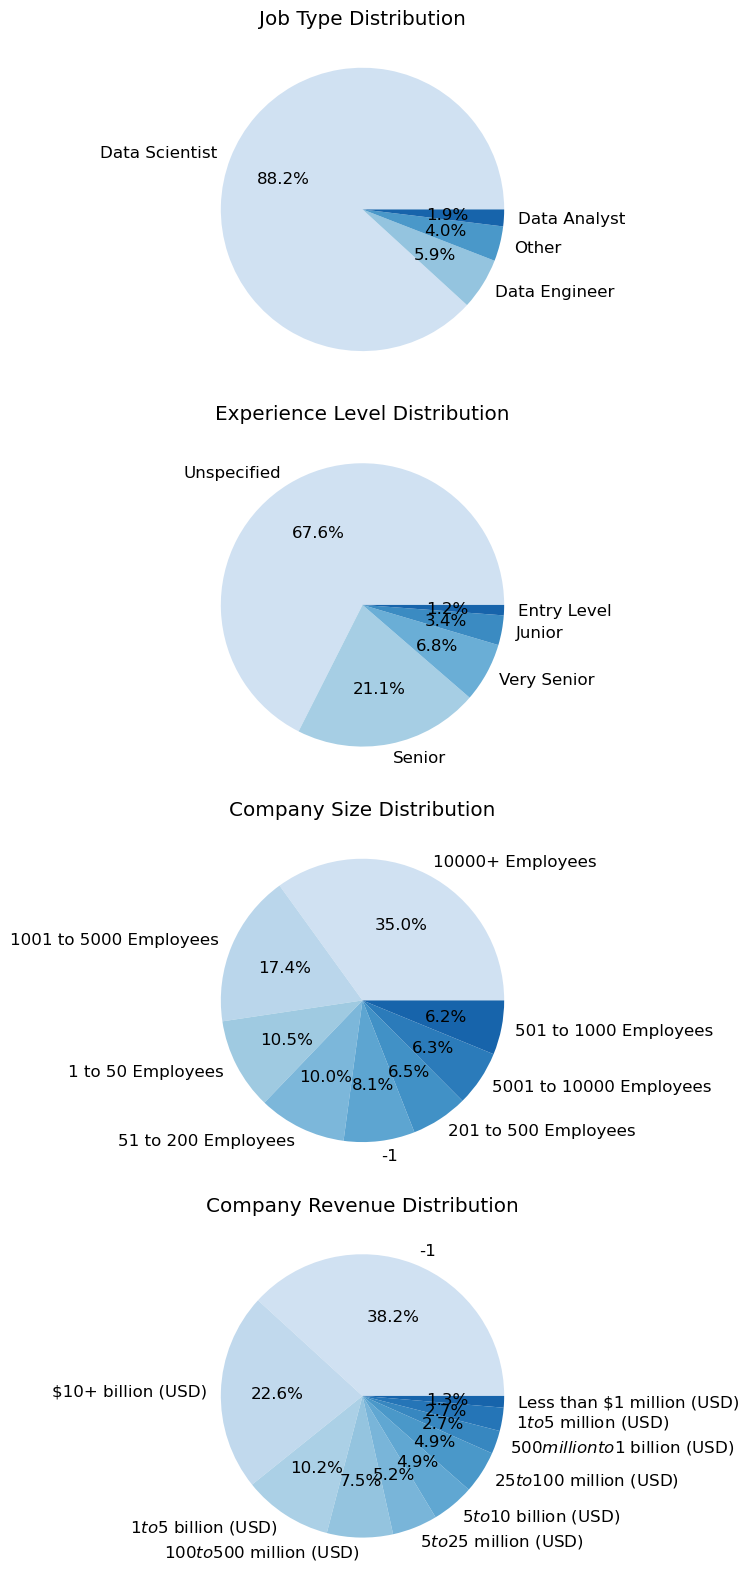

In [528]:
import matplotlib.pyplot as plt
from matplotlib.cm import Blues

# Set a common figsize for all plots
fig, axs = plt.subplots(4, 1, figsize=(16, 16))

# Job Type Distribution
value_counts = df['Job Type'].value_counts()
axs[0].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=Blues(np.linspace(0.2, 0.8, len(value_counts))))
axs[0].set_title('Job Type Distribution')

# Experience Level Distribution
value_counts = df['Experience Level'].value_counts()
axs[1].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=Blues(np.linspace(0.2, 0.8, len(value_counts))))
axs[1].set_title('Experience Level Distribution')

# Company Size Distribution
value_counts = df['Size'].value_counts()
axs[2].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=Blues(np.linspace(0.2, 0.8, len(value_counts))))
axs[2].set_title('Company Size Distribution')

# Company Revenue Distribution
value_counts = df['Revenue'].value_counts()
axs[3].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=Blues(np.linspace(0.2, 0.8, len(value_counts))))
axs[3].set_title('Company Revenue Distribution')

# Adjust layout
plt.tight_layout()

plt.savefig('figures/EDA/pie_charts.png', dpi=300, bbox_inches='tight')

# Show the plots
plt.show()

## Part 2: Preprocessing

In [529]:
# collect the various features
cat_ftrs = ['Location', 'State', 'Type of ownership', 'Industry', 'Job Type']
ordinal_ftrs = ['Size', 'Revenue', 'Experience Level']
ordinal_cats = [['-1', '1 to 50 Employees', '51 to 200 Employees', '201 to 500 Employees',
                '501 to 1000 Employees', '1001 to 5000 Employees', '5001 to 10000 Employees',
                '10000+ Employees'],
                ['-1', 'Less than $1 million (USD)', '$1 to $5 million (USD)', '$5 to $25 million (USD)',
                '$25 to $100 million (USD)', '$100 to $500 million (USD)',
                '$500 million to $1 billion (USD)', '$1 to $5 billion (USD)',
                '$5 to $10 billion (USD)', '$10+ billion (USD)'],
                ['Entry Level', 'Junior', 'Unspecified', 'Senior', 'Very Senior']]
num_ftrs = ['Rating', 'Founded', 'Python', 'R', 'SQL', 'AI']

In [530]:
# preprocess with pipeline and columntransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")

# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

# ordinal encoder
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

### Multivariate Imputation

In [531]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression

# imputer = IterativeImputer(estimator = RandomForestRegressor(n_estimators=1), random_state=42)
# # imputer = IterativeImputer(estimator = LinearRegression(), random_state=42)
# X_impute = imputer.fit_transform(df_train)
# df_train_imp = pd.DataFrame(data=X_impute, columns = df_train.columns)

# df_CV_imp = pd.DataFrame(data=imputer.transform(df_CV), columns = df_train.columns)
# df_test_imp = pd.DataFrame(data=imputer.transform(df_test), columns = df_train.columns)

### Reduced-features model

In [532]:
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm

In [533]:
mask = df[df.columns].isnull()

unique_rows, counts = np.unique(mask, axis=0,return_counts=True)
print(unique_rows.shape) # 6 patterns, we will train 6 models
for i in range(len(counts)):
    # print True feature names
    for j in range(len(unique_rows[i])):
        if unique_rows[i][j] == True:
            print(ftrs[j])
    print(unique_rows[i],counts[i])

(1, 22)
[False False False False False False False False False False False False
 False False False False False False False False False False] 678


In [534]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_params = {'max_depth': [1, 3, 10, 30, None],
             'max_features': [0.25, 0.5, 0.75, 1.0]}

# svr_model = SVR(kernel='linear')
svr_model = SVR()
svr_params = {'gamma': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
              'C': [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]}

knn_model = KNeighborsRegressor()
knn_params = {"n_neighbors": range(1, 21),
              "weights": ['uniform', 'distance']}

elastic_model = ElasticNet()
elastic_params = {'alpha': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
                  'l1_ratio': np.linspace(0, 1, 5)}

linreg_model = LinearRegression()
linreg_params = {}

# Run everything!

In [535]:
## UNCOMMENT LATER ##

# -1 represents missing values
df.replace(-1, np.nan, inplace=True)

# drop columns that are not useful for our analysis
to_exclude = ['Job Title', 'Job Description', 'Salary Estimate', 'Low_Salary', 'High_Salary']
df.drop(columns=to_exclude, inplace=True)

# the target variable
y = df['Avg_Salary']
df.drop(columns=['Avg_Salary'],inplace=True)
# the unprocessed feature matrix
unprocessed_X = df.values
print(unprocessed_X.shape)
# the feature names
groups = df['Company Name']
df.drop(columns=['Company Name'],inplace=True)
ftrs = df.columns
X = df

(678, 16)


In [536]:
def preprocess(X_train, X_CV, X_test):
    # fit_transform the training set
    X_prep = preprocessor.fit_transform(X_train)
    final_scaler = StandardScaler()
    X_prep = final_scaler.fit_transform(X_prep)
    
    # collect feature names
    feature_names = preprocessor.get_feature_names_out()

    df_train = pd.DataFrame(data=X_prep,columns=feature_names)

    df_CV = preprocessor.transform(X_CV)
    df_CV = final_scaler.transform(df_CV)
    df_CV = pd.DataFrame(data=df_CV,columns = feature_names)

    # transform the test
    df_test = preprocessor.transform(X_test)
    df_test = final_scaler.transform(df_test)
    df_test = pd.DataFrame(data=df_test,columns = feature_names)

    return df_train, df_CV, df_test

In [537]:
from sklearn.inspection import permutation_importance

def plot_perm_importance(model, df_test, y_test, ftr_names, folder, random_state):

    # ftr_names = df_test.columns
    y_test_pred = model.predict(df_test)

    test_score = np.sqrt(mean_squared_error(y_test,y_test_pred))

    # get the permutation importances
    result = permutation_importance(model, df_test, y_test, scoring='neg_root_mean_squared_error', n_repeats=10, random_state=random_state)
    sorted_idx = result.importances_mean.argsort()
    # add test score to each importance score value
    vals = np.array(result.importances[sorted_idx[-10:]].T)
    vals = vals + test_score

    # plot the top 10 most important features
    # plt.rcParams.update({'font.size': 13})
    plt.figure(figsize=(6,3))
    plt.boxplot(vals,labels=ftr_names[sorted_idx[-10:]],vert=False)
    plt.axvline(test_score,label='test score')
    plt.title("Permutation Importances (test set)")
    plt.xlabel('RMSE with perturbed feature')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'figures/{folder}/perm_importance.png',dpi=300, bbox_inches='tight')
    plt.show()

In [538]:
def plot_XGB_importance(XGB, folder):
    booster = XGB.get_booster()

    total_gain = booster.get_score(importance_type='total_gain')
    gain = booster.get_score(importance_type='gain')
    total_cover = booster.get_score(importance_type='total_cover')
    cover = booster.get_score(importance_type='cover')
    weight = booster.get_score(importance_type='weight')

    def make_plot(metric, name):
        # sort the dictionary by value
        metric = sorted(metric.items(), key=lambda x: x[1], reverse=True)
        metric = metric[:10]
        # reverse the order again before graphing
        metric = metric[::-1]
        metric = dict(metric)
        plt.figure(figsize=(7,3))
        plt.barh(list(metric.keys()), metric.values())
        plt.xlabel('importance score')
        # plt.ylabel('feature name')
        plt.title('Feature Importance Using ' + name)
        plt.tight_layout()
        plt.savefig(f'figures/{folder}/{name}.png',dpi=300)
        plt.show()

    metrics = [total_gain, gain, total_cover, cover, weight]
    names = ['total_gain', 'gain', 'total_cover', 'cover', 'weight']

    for metric, name in zip(metrics, names):
        make_plot(metric, name)

In [539]:
import shap
shap.initjs()
def plot_shap(model, X_test, y_test, feature_names, folder):
    # feature_names = df_test.columns
    explainer = shap.Explainer(model.predict, X_test)
    X_test_transformed = X_test #preprocessor.transform(X_test)
    shap_values = explainer.shap_values(X_test_transformed)
    shap_summary = np.abs(shap_values).mean(axis=0)
    indcs = np.argsort(shap_summary)

    ## GLOBAL SHAP ##
    # shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, plot_type="bar", max_display=10)

    plt.figure(figsize=(6,3))
    plt.barh(feature_names[indcs[-10:]], shap_summary[indcs[-10:]])
    plt.xlabel('mean(|SHAP value|)')
    # plt.ylabel('feature name')
    plt.title('SHAP Feature Importance')
    plt.savefig(f'figures/{folder}/global_shap.png', dpi=300, bbox_inches='tight')
    plt.show()

    ## LOCAL SHAP ##
    expected_value = np.mean(y_test)

    for index in [0,1,2]:
        formatted_features = np.round(np.array(X_test_transformed)[index], decimals=2)
        print(f'Force plot for data point at index {index}:')

        shap.force_plot(
            expected_value, #explainer.expected_value, 
            shap_values[index, :], 
            features=formatted_features,
            feature_names=feature_names,
            text_rotation=5,
            matplotlib=True,
            show=False
        )
        
        # save the figure
        # shap.save_html(f'figures/{folder}/datapoint{index}.html', to_save)
        # plt.savefig(f'figures/{folder}/datapoint{index}.png', bbox_inches='tight')
        plt.savefig(f'figures/{folder}/datapoint{index}.png',dpi=300, bbox_inches='tight')
        # plt.show()

        shap.force_plot(
            expected_value, #explainer.expected_value, 
            shap_values[index, :], 
            features=formatted_features,
            feature_names=feature_names,
            show=True,
            matplotlib=True,
            text_rotation=5
        )

In [557]:
def plot_true_vs_pred(ML_algo, y_test, all_y_test_pred, folder):
     # Make a scatterplot of true vs predicted values
    plt.figure(figsize=(5,4))
    plt.scatter(y_test, all_y_test_pred)
    plt.xlabel('true values')
    plt.ylabel('predicted values')
    # add a horizontal line with avg y_test value
    plt.axhline(y_test.mean(),color='gray',label='average y_test')
    if isinstance(ML_algo, ElasticNet):
        plt.title('Elastic Net Predictions')
    if isinstance(ML_algo, SVR):
        plt.title('SVR Predictions')
    if isinstance(ML_algo, xgboost.XGBRegressor):
        plt.title('XGBoost Predictions')
    if isinstance(ML_algo, RandomForestRegressor):
        plt.title('Random Forest Predictions')
    if isinstance(ML_algo, KNeighborsRegressor):
        plt.title('KNN Predictions')
    plt.tight_layout()
    plt.savefig(f'figures/{folder}/predictions.png',dpi=300)
    plt.show()

In [541]:
def plot_algo_specific_importance(ML_algo, feature_names, folder):
    if not isinstance(ML_algo, KNeighborsRegressor):
        plt.figure(figsize=(6,3))

    if isinstance(ML_algo, ElasticNet):
        coefs = ML_algo.coef_
        sorted_indcs = np.argsort(np.abs(coefs))
        plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
        plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
        plt.xlabel('coefficient')
        plt.title('Linear Feature Importance (Coefficients)')
        plt.tight_layout()
        plt.savefig(f'figures/{folder}/LR_coefs_scaled.png',dpi=300)
        plt.show()

    if isinstance(ML_algo, svm.SVR):
        coefs = ML_algo.coef_
        sorted_indcs = np.argsort(np.abs(coefs))
        plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
        plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
        plt.xlabel('coefficient')
        plt.title('SVR Feature Importance (Coefficients)')
        plt.tight_layout()
        plt.savefig(f'figures/{folder}/SVR_coefs_scaled.png',dpi=300, bbox_inches='tight')
        plt.show()

    if isinstance(ML_algo, xgboost.XGBRegressor):
        coefs = ML_algo.feature_importances_
        sorted_indcs = np.argsort(np.abs(coefs))
        plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
        plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
        plt.xlabel('gain score')
        plt.title('XGB Feature Importance (Gain)')
        plt.tight_layout()
        plt.savefig(f'figures/{folder}/XGB_importances.png',dpi=300, bbox_inches='tight')
        plt.show()
        
    if isinstance(ML_algo, RandomForestRegressor):
        coefs = ML_algo.feature_importances_
        sorted_indcs = np.argsort(np.abs(coefs))
        plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
        plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
        plt.xlabel('Gini impurity')
        plt.title('Random Forest Feature Importance (Gini)')
        plt.tight_layout()
        plt.savefig(f'figures/{folder}/RF_importances.png',dpi=300, bbox_inches='tight')
        plt.show()

In [542]:
def get_folder(ML_algo):
    if isinstance(ML_algo, ElasticNet):
        return 'ElasticNet'
    if isinstance(ML_algo, SVR):
        return 'SVR'
    if isinstance(ML_algo, xgboost.XGBRegressor):
        return 'XGBoost'
    if isinstance(ML_algo, RandomForestRegressor):
        return 'RandomForest'
    if isinstance(ML_algo, KNeighborsRegressor):
        return 'KNN'

In [543]:
import pandas as pd
import shap

shap.initjs() # required for visualizations later on

def best_model(X_train, y_train, X_CV, y_CV, X_test, y_test, ML_algo, param_grid, importance, counter, verbose=0):

    # make into row vectors to avoid an obnoxious sklearn/xgb warning
    y_train = np.reshape(np.array(y_train), (1, -1)).ravel()
    y_CV = np.reshape(np.array(y_CV), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

    pg = ParameterGrid(param_grid)

    scores = np.zeros(len(pg))

    for i in range(len(pg)):
        if verbose >= 5:
            print("Param set " + str(i + 1) + " / " + str(len(pg)))
        params = pg[i]
        ML_algo.set_params(**params)
        eval_set = [(X_CV, y_CV)]
        if isinstance(ML_algo, xgboost.XGBRegressor):
            ML_algo.fit(X_train, y_train,
                    early_stopping_rounds=50, eval_set=eval_set, verbose=False)# with early stopping
            y_CV_pred = ML_algo.predict(X_CV, ntree_limit=ML_algo.best_ntree_limit)
        else:
            ML_algo.fit(X_train, y_train)
            y_CV_pred = ML_algo.predict(X_CV)
        scores[i] = mean_squared_error(y_CV,y_CV_pred)

    # Goal is to *minimize* the score
    best_params = np.array(pg)[scores == np.min(scores)]
    print(best_params)
    if verbose >= 4:
        print('Test set min score and best parameters are:')
        print(np.min(scores)**0.5)
        print(best_params)

    # test the model on the test set with best parameter set
    ML_algo.set_params(**best_params[0])
    if isinstance(ML_algo, xgboost.XGBRegressor):
        ML_algo.fit(X_train,y_train,
        early_stopping_rounds=50,eval_set=eval_set, verbose=False)
        y_test_pred = ML_algo.predict(X_test, ntree_limit=ML_algo.best_ntree_limit)
    else:
        ML_algo.fit(X_train,y_train)
        y_test_pred = ML_algo.predict(X_test)

    if verbose >= 1:
        print ('The RMSE is:', mean_squared_error(y_test,y_test_pred)**0.5)
    if verbose >= 2:
        pass
        # print ('The predictions are:')
        # print (y_test_pred)
    if verbose >= 3:
        pass
        # print("Feature importances:")
        # print(XGB.feature_importances_)

    test_score = mean_squared_error(y_test,y_test_pred)

    return (test_score, y_test_pred, ML_algo)

# Create a generic reduced_feature function
# all the inputs need to be pandas DataFrame
def reduced_feature(X_train, Y_train, X_CV, y_CV, X_test, y_test, ML_algo, param_grid, importance, xgb_missing, random_state):

    counter = 0
    folder = get_folder(ML_algo)

    # find all unique patterns of missing value in test set
    mask = X_test.isnull()
    unique_rows = np.array(np.unique(mask, axis=0))
    all_y_test_pred = pd.DataFrame()

    best_mods = []
    
    if counter == 0:
        print('there are', len(unique_rows), 'unique missing value patterns.')
    
    # divide test sets into subgroups according to the unique patterns
    for i in range(len(unique_rows)):
        print ('working on unique pattern', i)
        ## generate X_test subset that matches the unique pattern i
        sub_X_test = pd.DataFrame()
        sub_y_test = pd.Series(dtype=float)
        for j in range(len(mask)): # check each row in mask
            row_mask = np.array(mask.iloc[j])
            if np.array_equal(row_mask, unique_rows[i]): # if the pattern matches the ith unique pattern

                sub_X_test = pd.concat([sub_X_test,X_test.iloc[[j]]])# append the according X_test row j to the subset
                sub_y_test = pd.concat([sub_y_test, y_test.iloc[[j]]])# append the according y_test row j

        sub_X_test = sub_X_test[X_test.columns[~unique_rows[i]]]
        
        ## choose the according reduced features for subgroups
        sub_X_train = pd.DataFrame()
        sub_Y_train = pd.DataFrame()
        sub_X_CV = pd.DataFrame()
        sub_y_CV = pd.DataFrame()
        # 1.cut the feature columns that have nans in the according sub_X_test
        sub_X_train = X_train[X_train.columns[~unique_rows[i]]]
        sub_X_CV = X_CV[X_CV.columns[~unique_rows[i]]]
        # 2.cut the rows in the sub_X_train and sub_X_CV that have any nans
        sub_X_train = sub_X_train.dropna()
        sub_X_CV = sub_X_CV.dropna()   
        # 3.cut the sub_Y_train and sub_y_CV accordingly
        sub_Y_train = Y_train.iloc[sub_X_train.index]
        sub_y_CV = y_CV.iloc[sub_X_CV.index]
        
        # run ML algorithm
        sub_y_test_pred = best_model(sub_X_train, sub_Y_train, sub_X_CV, 
                                       sub_y_CV, sub_X_test, sub_y_test, ML_algo, param_grid, importance, counter)
        best_mod = sub_y_test_pred[2]
        best_mods.append(best_mod)
        sub_y_test_pred = pd.DataFrame(sub_y_test_pred[1],columns=['sub_y_test_pred'],
                                          index=sub_y_test.index)
        # print('   RMSE:', np.sqrt(mean_squared_error(sub_y_test,sub_y_test_pred)))
        # collect the test predictions
        all_y_test_pred = pd.concat([all_y_test_pred, sub_y_test_pred])

        if counter == 0 and importance:
            if isinstance(best_mod, xgboost.XGBRegressor):
                plot_XGB_importance(best_mod, folder)
            ftr_names = sub_X_test.columns
            plot_algo_specific_importance(best_mod, ftr_names, folder)
            plot_perm_importance(best_mod, sub_X_test, sub_y_test, ftr_names, folder, random_state)
            plot_shap(best_mod, sub_X_test, sub_y_test, ftr_names, folder)
        
        counter += 1
        
    # rank the final y_test_pred according to original y_test index
    all_y_test_pred = all_y_test_pred.sort_index()
    y_test = y_test.sort_index()
    
    # get global RMSE
    total_RMSE = np.sqrt(mean_squared_error(y_test,all_y_test_pred))
    total_R2 =  r2_score(y_test,all_y_test_pred)

    if counter == 0:
        plot_true_vs_pred(ML_algo, y_test, all_y_test_pred, folder)

    return total_RMSE, total_R2, best_mods

In [544]:
def xgb_with_missing(X_train, Y_train, X_CV, y_CV, X_test, y_test, ML_algo, param_grid, importance, random_state):
    # run ML algorithm
    y_test_pred = best_model(X_train, Y_train, X_CV, 
                                    y_CV, X_test, y_test, ML_algo, param_grid, importance, counter=0)
    best_mod = y_test_pred[2]
   
    y_test_pred = pd.DataFrame(y_test_pred[1],columns=['y_test_pred'],
                                        index=y_test.index)
    print('   RMSE:', np.sqrt(mean_squared_error(y_test,y_test_pred)))

    folder = 'XGB_missing'
    
    if importance:
        if isinstance(best_mod, xgboost.XGBRegressor):
            plot_XGB_importance(best_mod, folder)
        ftr_names = X_test.columns
        plot_algo_specific_importance(best_mod, ftr_names, folder)
        plot_perm_importance(best_mod, X_test, y_test, ftr_names, folder, random_state)
        plot_shap(best_mod, X_test, y_test, ftr_names, folder)

    # rank the final y_test_pred according to original y_test index
    y_test_pred = y_test_pred.sort_index()
    y_test = y_test.sort_index()

    # get global RMSE
    total_RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))
    total_R2 =  r2_score(y_test, y_test_pred)

    plot_true_vs_pred(best_mod, y_test, y_test_pred, folder)

    return total_RMSE, total_R2, best_mod

In [566]:
from sklearn.model_selection import GroupShuffleSplit

def get_performance(ML_algo, params, n_states=5, importance=False, xgb_missing=False):
    RMSE_scores = []
    baseline_scores = []
    R2_scores = []

    # Loop through n different random states
    for random_state in range(n_states):
        gss = GroupShuffleSplit(n_splits=1, train_size=0.6, random_state=random_state)
        gss_second_split = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=random_state)

        for train_idx, other_idx in gss.split(X, y, groups):
            X_train = X.iloc[train_idx]
            y_train = y.iloc[train_idx]
            X_other = X.iloc[other_idx]
            y_other = y.iloc[other_idx]
            second_split_groups = groups.iloc[other_idx]
            for val_idx, test_idx in gss_second_split.split(X_other, y_other, second_split_groups):
                X_CV, y_CV = X_other.iloc[val_idx], y_other.iloc[val_idx]
                X_test, y_test = X_other.iloc[test_idx], y_other.iloc[test_idx]

        print('X_train shape:', X_train.shape)
        print('X_CV shape:', X_CV.shape)
        print('X_test shape:', X_test.shape)

        df_train, df_CV, df_test = preprocess(X_train, X_CV, X_test)

        ## Drop perfectly collinear features
        ####################################################
        corr_buffer = 0.01
        corr_matrix = df_train.corr()
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i + 1, len(corr_matrix.columns)):
                if abs(corr_matrix.iloc[i, j]) >= 1 - corr_buffer:
                    high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))
        # print(high_corr_pairs)
        columns_to_drop = set()
        for col1, col2 in high_corr_pairs:
            if col1 in df_train.columns and col2 in df_train.columns:
                if df_train.columns.get_loc(col1) > df_train.columns.get_loc(col2):
                    columns_to_drop.add(col1)
                else:
                    columns_to_drop.add(col2)
        df_train = df_train.drop(columns=columns_to_drop, axis=1)
        df_CV = df_CV.drop(columns=columns_to_drop, axis=1)
        df_test = df_test.drop(columns=columns_to_drop, axis=1)
        corr_matrix = df_train.corr()
        # high_corr_pairs = []
        # for i in range(len(corr_matrix.columns)):
        #     for j in range(i + 1, len(corr_matrix.columns)):
        #         if abs(corr_matrix.iloc[i, j]) >= 1 - corr_buffer:
        #             high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))
        # print(high_corr_pairs)
        ####################################################

        if isinstance(ML_algo, RandomForestRegressor):
            ML_algo.set_params(random_state=random_state)
        if isinstance(ML_algo, xgboost.XGBRegressor):
            ML_algo.set_params(seed=random_state)

        # Only calculate feature importance for the first random state
        if random_state != 0:
            importance = False

        if xgb_missing:
            RMSE, R2, best_mod = xgb_with_missing(df_train, y_train, df_CV, y_CV, df_test, y_test, ML_algo, params, importance, random_state)
        else:
            RMSE, R2, best_mod = reduced_feature(df_train, y_train, df_CV, y_CV, df_test, y_test, ML_algo, params, importance, xgb_missing, random_state)
        RMSE_scores.append(RMSE)
        R2_scores.append(R2)

        baseline_rmse = np.sqrt(np.mean((y_test - np.mean(y_test))**2))
        baseline_scores.append(baseline_rmse)
  
    baseline_avg = np.mean(baseline_scores)
    baseline_std = np.std(baseline_scores)
    
    print('Average RMSE:', np.mean(RMSE_scores))
    print('RMSE standard deviation:', np.std(RMSE_scores))
    print('Baseline RMSE:', baseline_avg)
    print('Baseline RMSE standard deviation:', baseline_std)

    return np.mean(RMSE_scores), np.std(RMSE_scores), baseline_avg, baseline_std



# XGB w/ missing values

X_train shape: (410, 15)
X_CV shape: (143, 15)
X_test shape: (125, 15)
[('cat__Location_Glendale, CA', 'cat__Industry_Real Estate'), ('cat__Location_Huntsville, AL', 'cat__State_AL'), ('cat__Location_Indianapolis, IN', 'cat__State_IN'), ('cat__Location_Kissimmee, FL', 'cat__Industry_Film Production'), ('cat__Location_Lincoln, NE', 'cat__State_NE'), ('cat__Location_Lincolnshire, IL', 'cat__Industry_Sporting Goods Stores'), ('cat__Location_Louisville, KY', 'cat__State_KY'), ('cat__Location_Manhattan', 'cat__Industry_Municipal Agencies'), ('cat__Location_Marlborough, MA', 'cat__Industry_Department, Clothing & Shoe Stores'), ('cat__Location_New York State', 'cat__Industry_Insurance Agencies & Brokerages'), ('cat__Location_Olathe, KS', 'cat__State_KS'), ('cat__Location_Pleasanton, CA', 'cat__Industry_Grocery Stores'), ('cat__Location_Point Loma', 'cat__Industry_Preschools & Child Care Services'), ('cat__Location_Portland, ME', 'cat__State_ME'), ('cat__Location_Portland, OR', 'cat__State_OR'

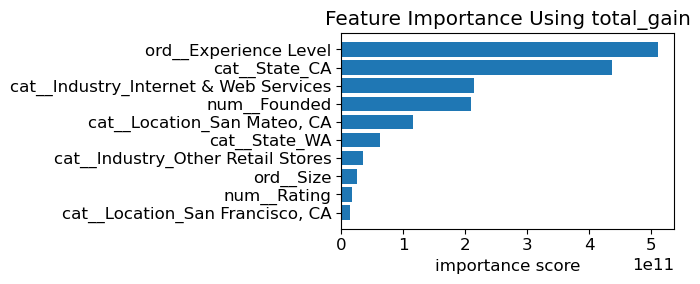

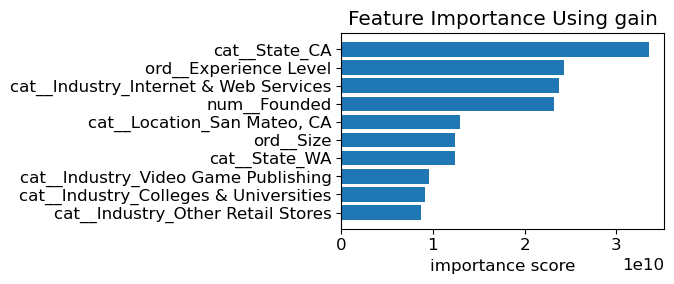

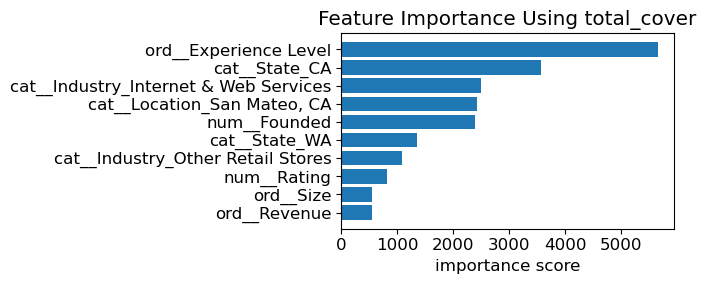

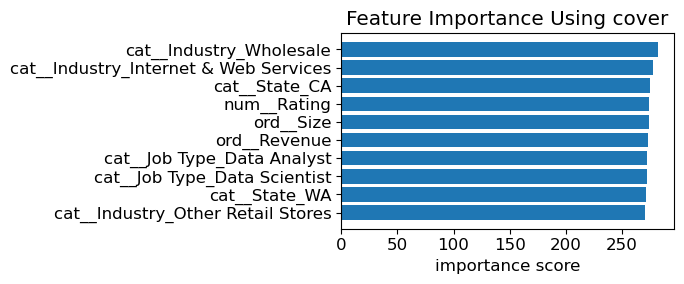

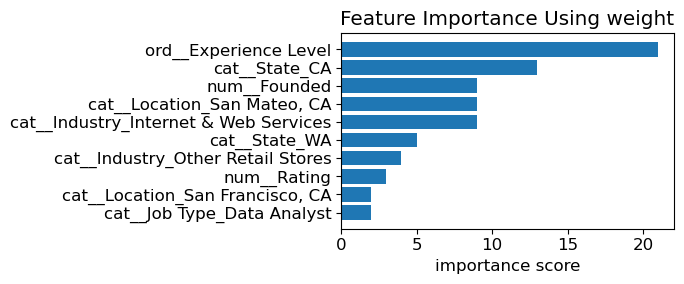

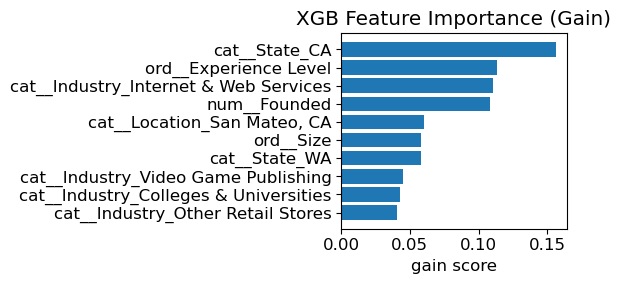

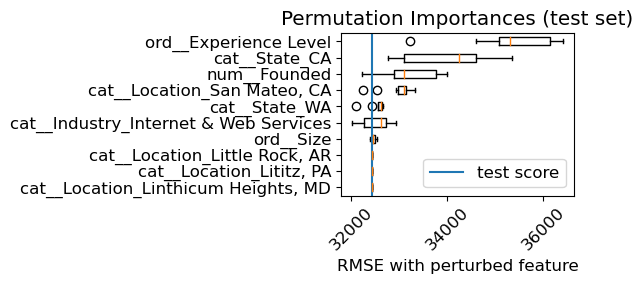

Permutation explainer: 126it [00:47,  2.08it/s]                         


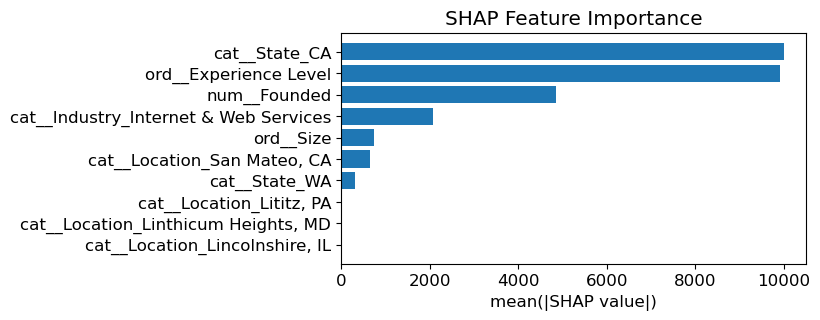

Force plot for data point at index 0:


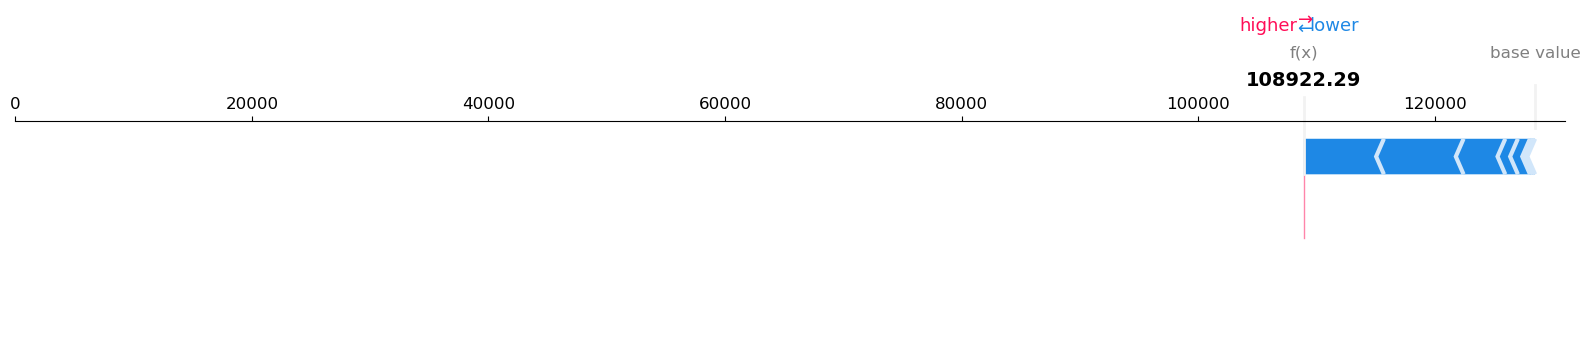

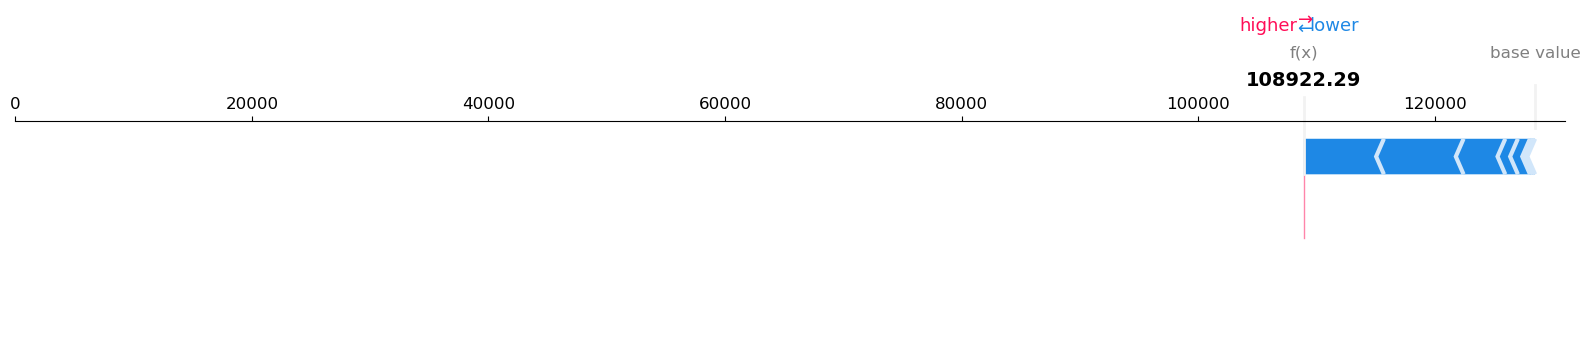

Force plot for data point at index 1:


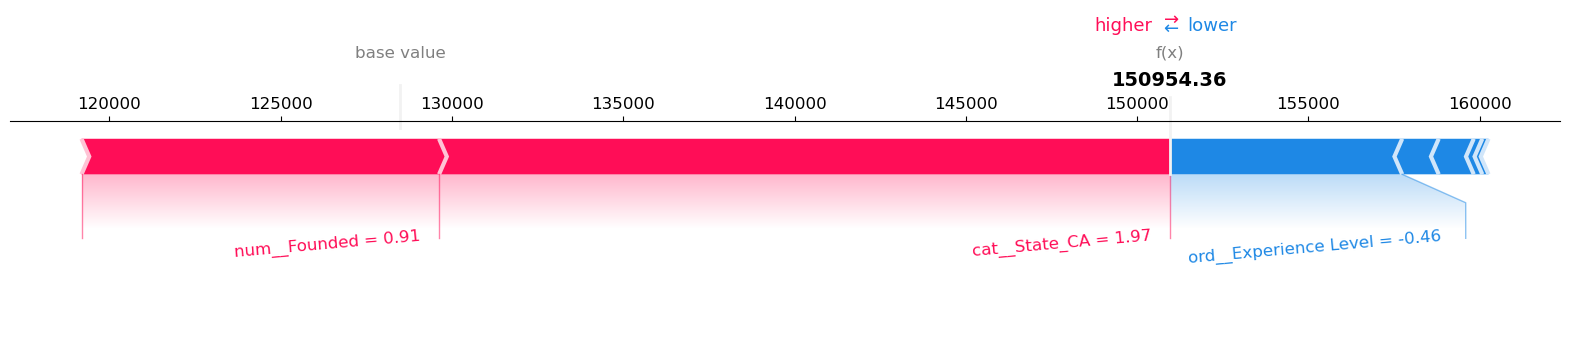

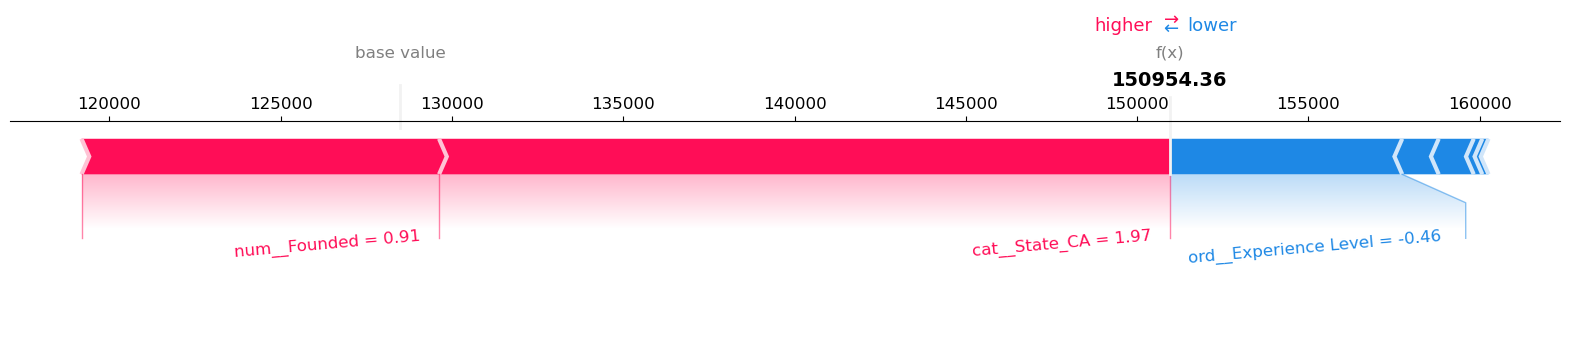

Force plot for data point at index 2:


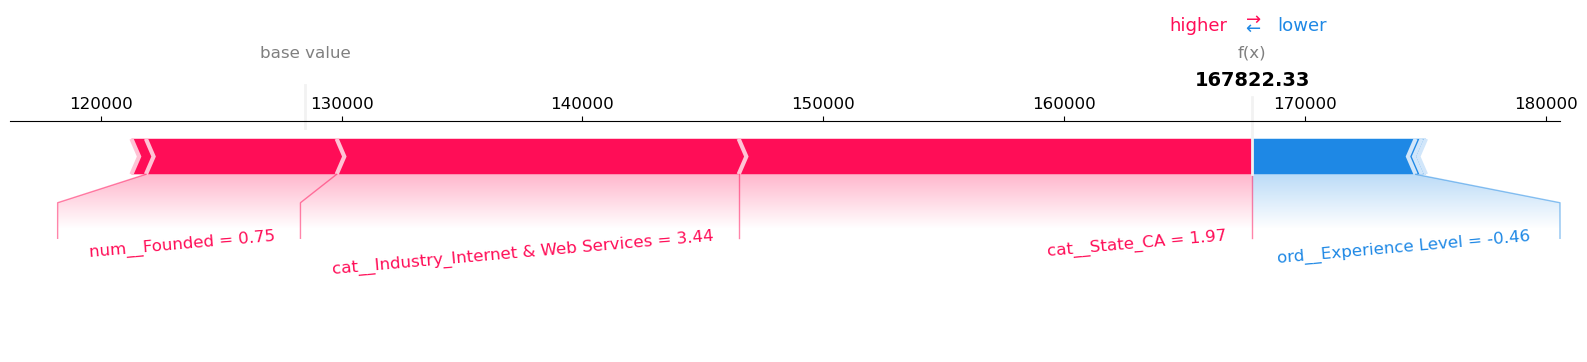

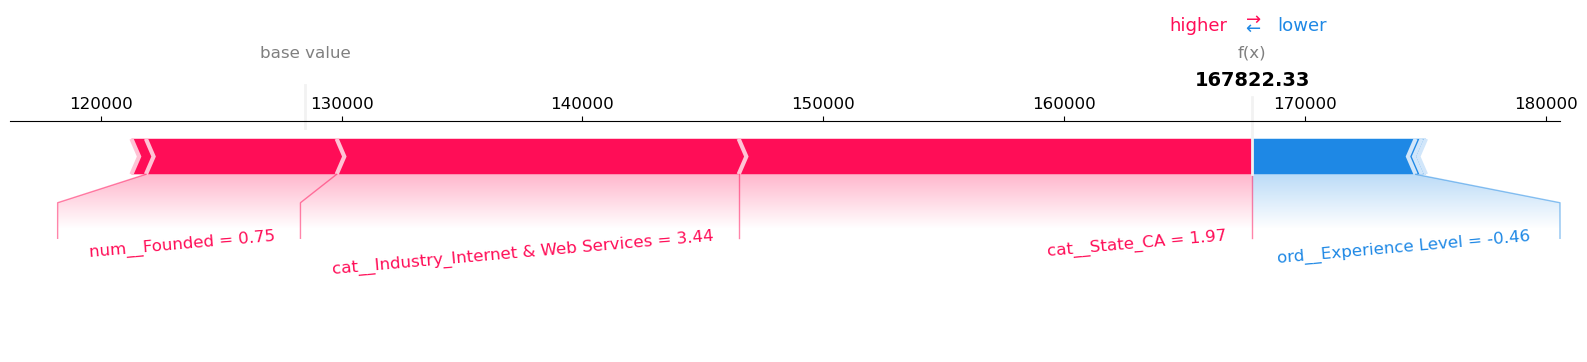

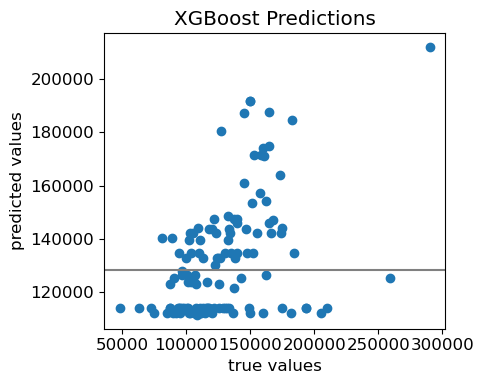

X_train shape: (405, 15)
X_CV shape: (131, 15)
X_test shape: (142, 15)
[('cat__Location_Beaverton, OR', 'cat__State_OR'), ('cat__Location_Camden, NJ', 'cat__Industry_Civic & Social Services'), ('cat__Location_Concord, NH', 'cat__State_NH'), ('cat__Location_Concord, NH', 'cat__Industry_State & Regional Agencies'), ('cat__Location_Fargo, ND', 'cat__State_ND'), ('cat__Location_Fargo, ND', 'cat__Industry_Architectural & Engineering Services'), ('cat__Location_Huntsville, AL', 'cat__State_AL'), ('cat__Location_Irving, TX', 'cat__Industry_Beauty & Wellness'), ('cat__Location_Lake Charles, LA', 'cat__State_LA'), ('cat__Location_Lincolnshire, IL', 'cat__Industry_Sporting Goods Stores'), ('cat__Location_Louisville, KY', 'cat__State_KY'), ('cat__Location_Monroe, WI', 'cat__Industry_Food & Beverage Stores'), ('cat__Location_New York State', 'cat__Industry_Insurance Agencies & Brokerages'), ('cat__Location_Olathe, KS', 'cat__State_KS'), ('cat__Location_Pleasanton, CA', 'cat__Industry_Grocery Store

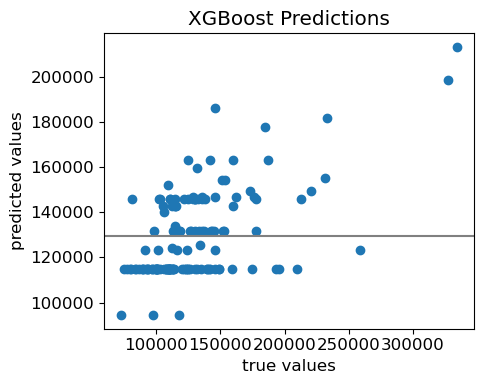

X_train shape: (397, 15)
X_CV shape: (138, 15)
X_test shape: (143, 15)
[('cat__Location_Cedar Rapids, IA', 'cat__State_IA'), ('cat__Location_Chesapeake, VA', 'cat__Industry_General Merchandise & Superstores'), ('cat__Location_Concord, NH', 'cat__State_NH'), ('cat__Location_Concord, NH', 'cat__Industry_State & Regional Agencies'), ('cat__Location_Englewood Cliffs, NJ', 'cat__Industry_Consumer Electronics & Appliances Stores'), ('cat__Location_Huntsville, AL', 'cat__State_AL'), ('cat__Location_Indianapolis, IN', 'cat__State_IN'), ('cat__Location_Jacksonville, FL', 'cat__Industry_Rail Transportation'), ('cat__Location_Lincoln, NE', 'cat__State_NE'), ('cat__Location_Lincolnshire, IL', 'cat__Industry_Sporting Goods Stores'), ('cat__Location_Little Rock, AR', 'cat__State_AR'), ('cat__Location_Louisville, KY', 'cat__State_KY'), ('cat__Location_Monroe, OH', 'cat__Industry_Shipping & Trucking'), ('cat__Location_Naples, FL', 'cat__Industry_Health Care Products Manufacturing'), ('cat__Location_Oa

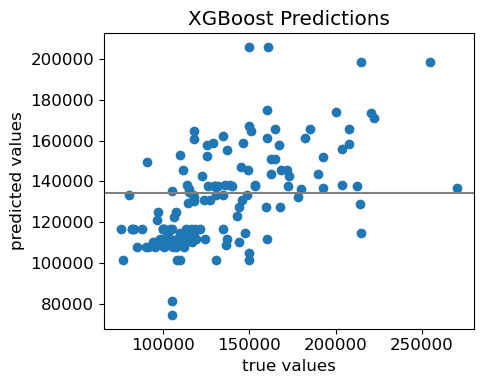

X_train shape: (416, 15)
X_CV shape: (132, 15)
X_test shape: (130, 15)
[('cat__Location_Concord, NH', 'cat__State_NH'), ('cat__Location_Concord, NH', 'cat__Industry_State & Regional Agencies'), ('cat__Location_Fargo, ND', 'cat__State_ND'), ('cat__Location_Huntsville, AL', 'cat__State_AL'), ('cat__Location_Indianapolis, IN', 'cat__State_IN'), ('cat__Location_Jacksonville, FL', 'cat__Industry_Rail Transportation'), ('cat__Location_Kissimmee, FL', 'cat__Industry_Film Production'), ('cat__Location_Lincoln, NE', 'cat__State_NE'), ('cat__Location_Lincolnshire, IL', 'cat__Industry_Sporting Goods Stores'), ('cat__Location_Louisville, KY', 'cat__State_KY'), ('cat__Location_Milwaukee, WI', 'cat__Industry_Machinery Manufacturing'), ('cat__Location_Monroe, OH', 'cat__Industry_Shipping & Trucking'), ('cat__Location_Oak Ridge, TN', 'cat__State_TN'), ('cat__Location_Olathe, KS', 'cat__State_KS'), ('cat__Location_Point Loma', 'cat__Industry_Preschools & Child Care Services'), ('cat__Location_Remote', 

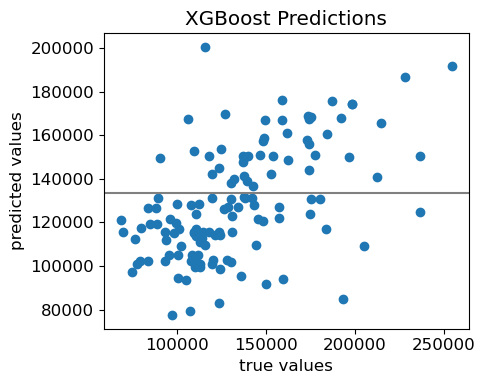

X_train shape: (401, 15)
X_CV shape: (138, 15)
X_test shape: (139, 15)
[('cat__Location_Brea, CA', 'cat__Industry_Health Care Products Manufacturing'), ('cat__Location_Concord, NH', 'cat__State_NH'), ('cat__Location_Concord, NH', 'cat__Industry_State & Regional Agencies'), ('cat__Location_Fargo, ND', 'cat__State_ND'), ('cat__Location_Fargo, ND', 'cat__Industry_Architectural & Engineering Services'), ('cat__Location_Huntsville, AL', 'cat__State_AL'), ('cat__Location_Indianapolis, IN', 'cat__State_IN'), ('cat__Location_Monroe, WI', 'cat__Industry_Food & Beverage Stores'), ('cat__Location_New York State', 'cat__Industry_Insurance Agencies & Brokerages'), ('cat__Location_Oak Ridge, TN', 'cat__State_TN'), ('cat__Location_Olathe, KS', 'cat__State_KS'), ('cat__Location_Point Loma', 'cat__Industry_Preschools & Child Care Services'), ('cat__Location_Portland, ME', 'cat__State_ME'), ('cat__Location_Remote', 'cat__State_Remote'), ('cat__Location_Reno, NV', 'cat__State_NV'), ('cat__Location_Smithf

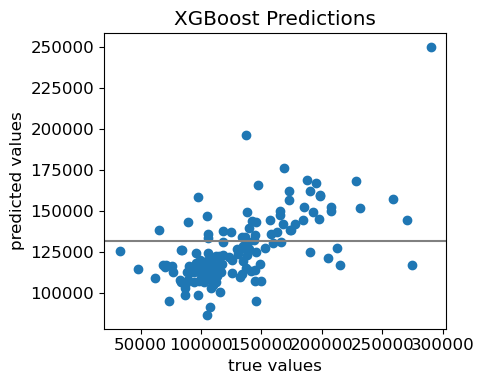

Average RMSE: 33180.59842237724
RMSE standard deviation: 2094.8568918805195
Baseline RMSE: 39679.35296482231
Baseline RMSE standard deviation: 3546.4424320837466


In [567]:
xgb_mod_missing = xgboost.XGBRegressor(n_jobs=1)
xgb_params = {'max_depth': [1, 2, 3, 10, 30, None],
              'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
              'missing': [np.nan], 
              'n_estimators': [10000],
              'colsample_bytree': [0.9],
              'subsample': [0.66]}
xgb_missing_mean, xgb_missing_std, baseline_avg, baseline_std = get_performance(xgb_mod_missing, xgb_params, importance=True, xgb_missing=True)

X_train shape: (410, 15)
X_CV shape: (143, 15)
X_test shape: (125, 15)
there are 3 unique missing value patterns.
working on unique pattern 0
[{'alpha': 10.0, 'l1_ratio': 0.75}]


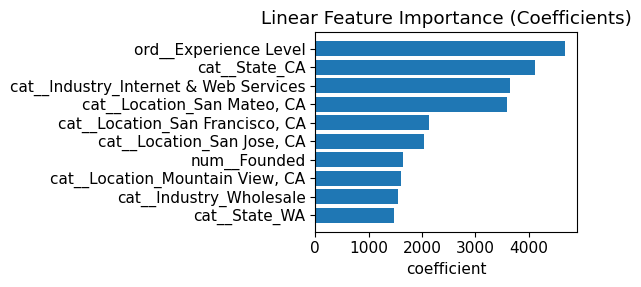

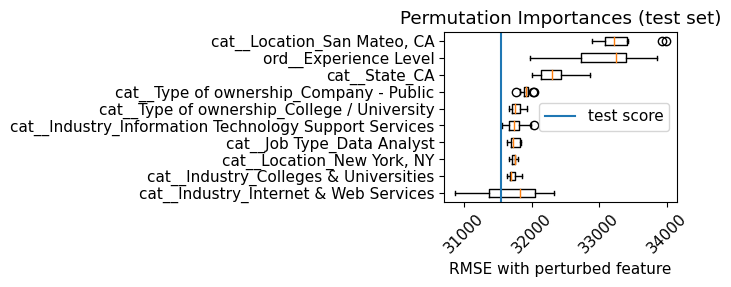

Permutation explainer: 108it [00:42,  1.99it/s]                         


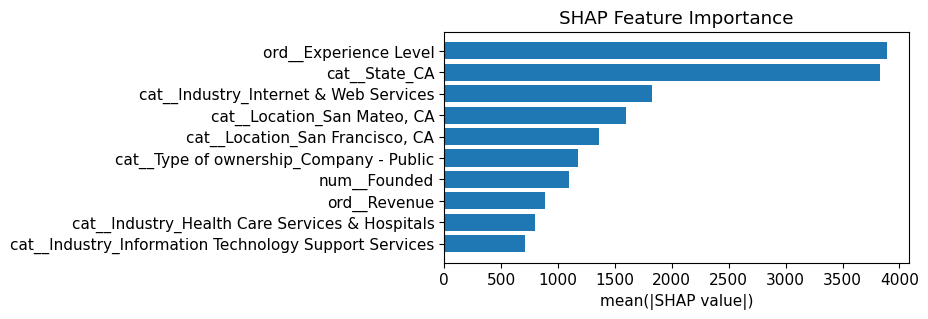

Force plot for data point at index 0:


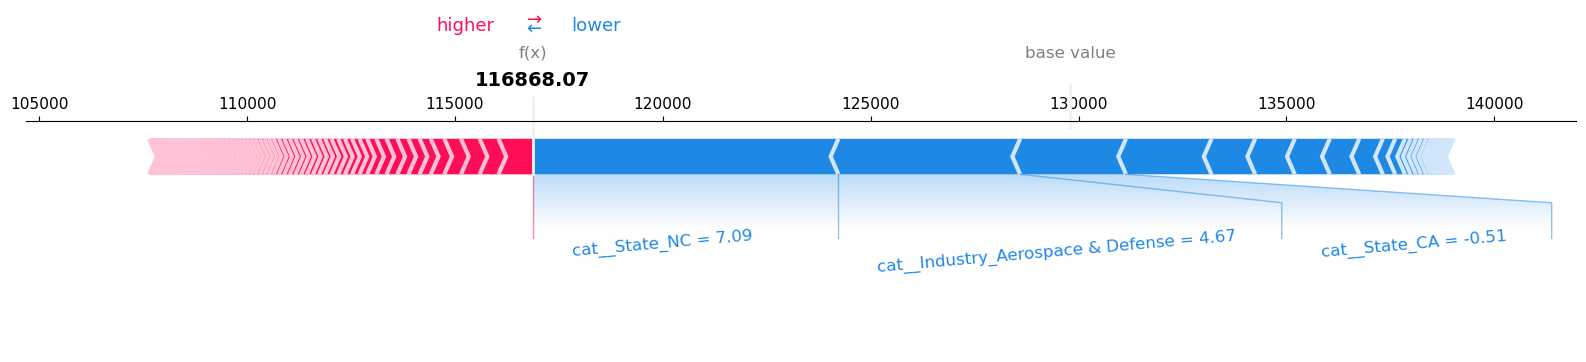

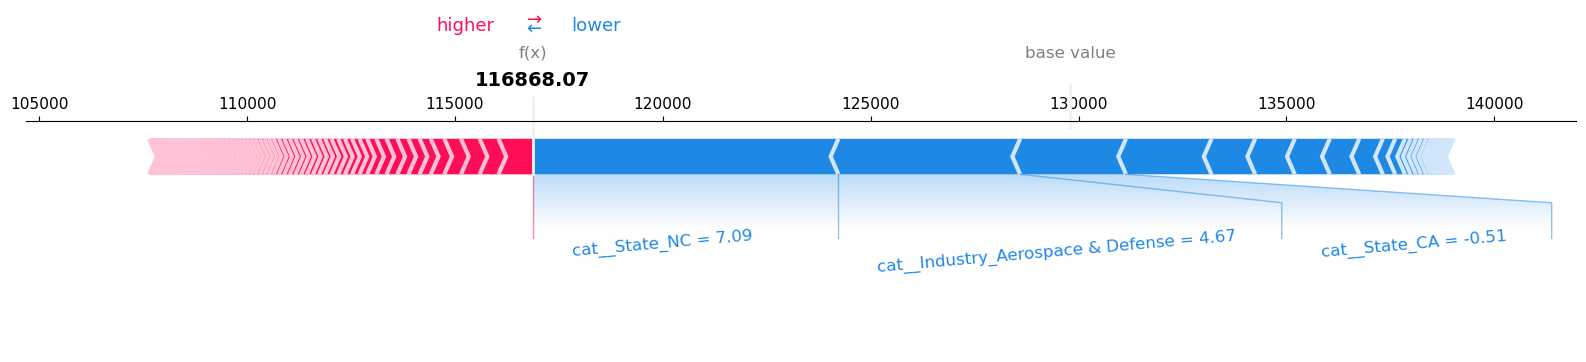

Force plot for data point at index 1:


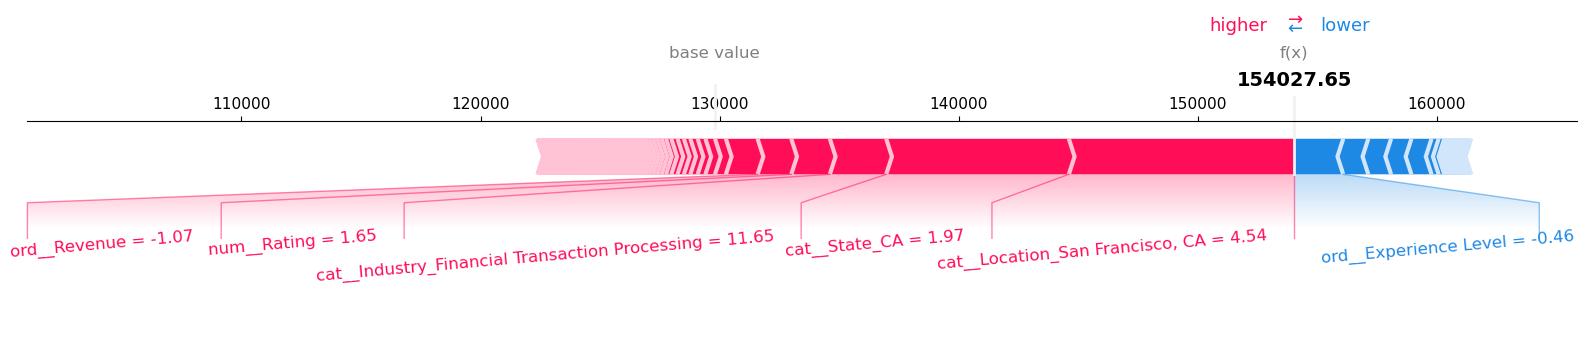

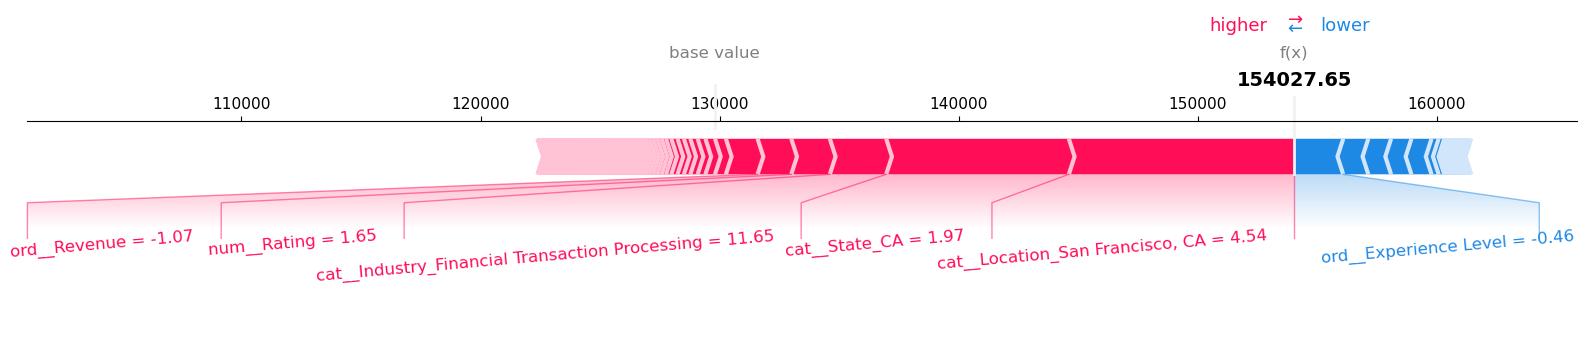

Force plot for data point at index 2:


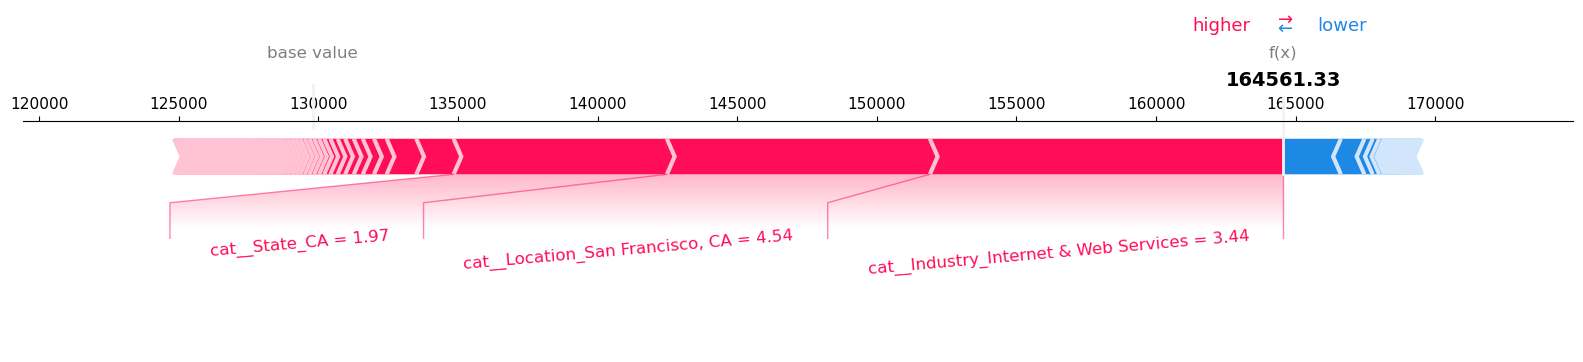

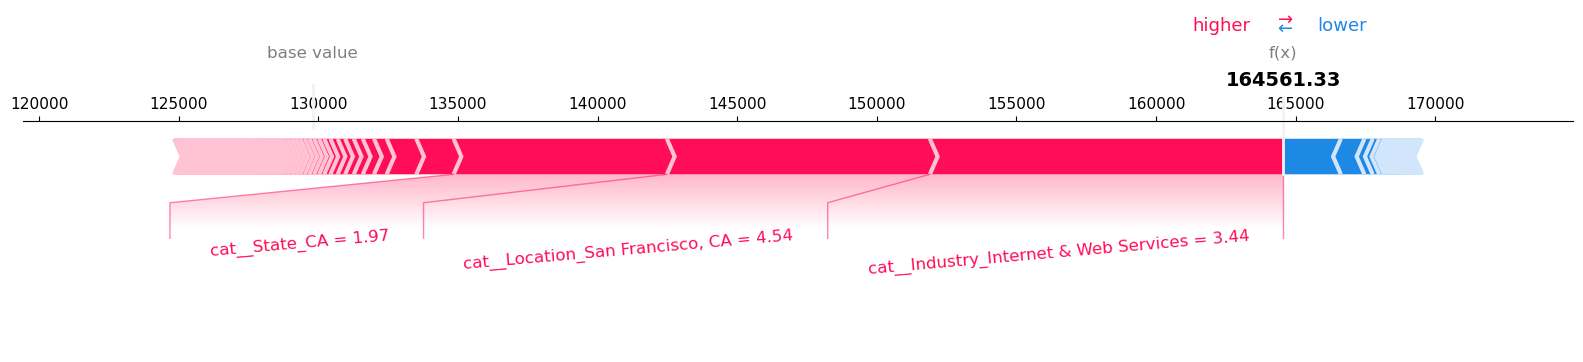

working on unique pattern 1
[{'alpha': 10.0, 'l1_ratio': 0.75}]
working on unique pattern 2
[{'alpha': 10.0, 'l1_ratio': 0.75}]
X_train shape: (405, 15)
X_CV shape: (131, 15)
X_test shape: (142, 15)
there are 3 unique missing value patterns.
working on unique pattern 0
[{'alpha': 10.0, 'l1_ratio': 0.75}]
working on unique pattern 1
[{'alpha': 10.0, 'l1_ratio': 0.75}]
working on unique pattern 2
[{'alpha': 10.0, 'l1_ratio': 0.75}]
Average RMSE: 33184.37212986178
RMSE standard deviation: 1258.6895302674748
Baseline RMSE: 38239.093688193854
Baseline RMSE standard deviation: 2534.3063324262002


In [ ]:
elastic_mean, elastic_std, baseline_rmse, baseline_std = get_performance(elastic_model, elastic_params, importance=True)

X_train shape: (410, 15)
X_CV shape: (143, 15)
X_test shape: (125, 15)
there are 3 unique missing value patterns.
working on unique pattern 0
[{'max_depth': None, 'max_features': 0.25}]


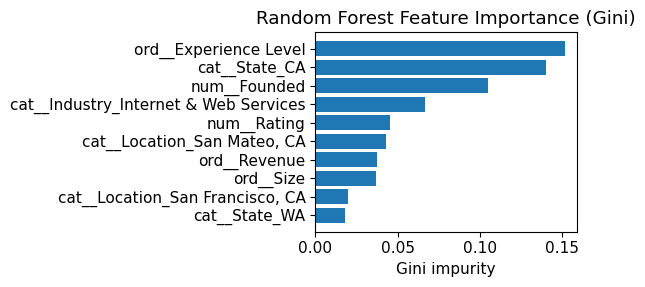

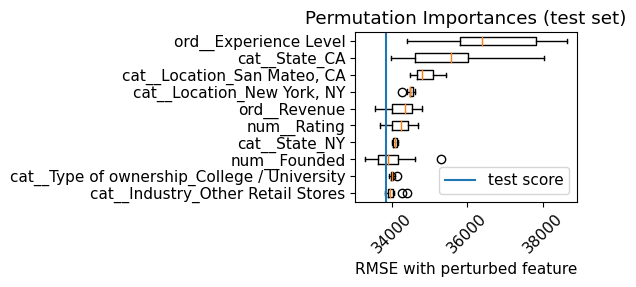

Permutation explainer: 108it [01:22,  1.14it/s]                         


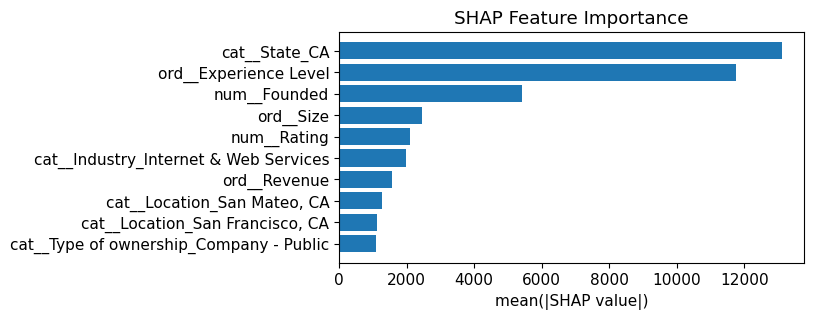

Force plot for data point at index 0:


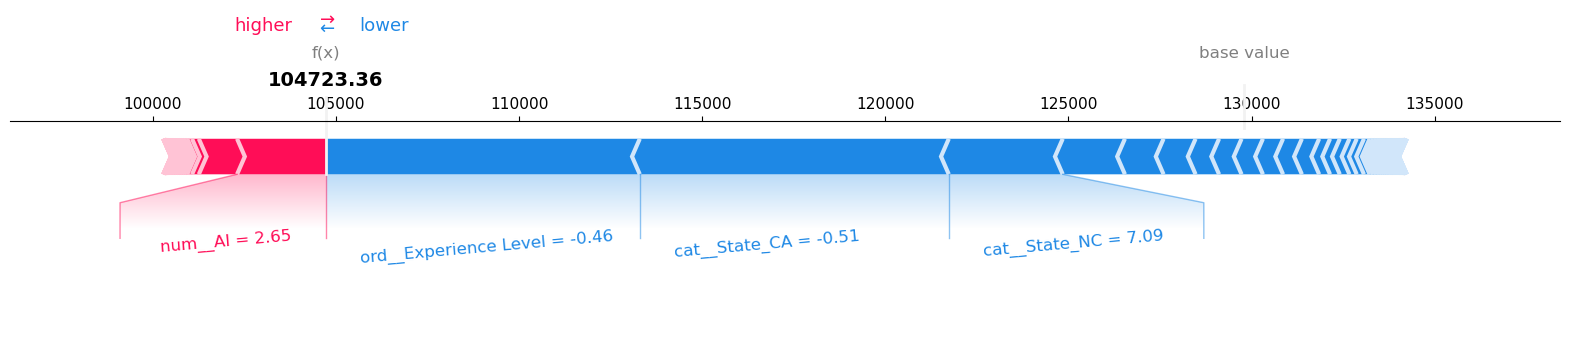

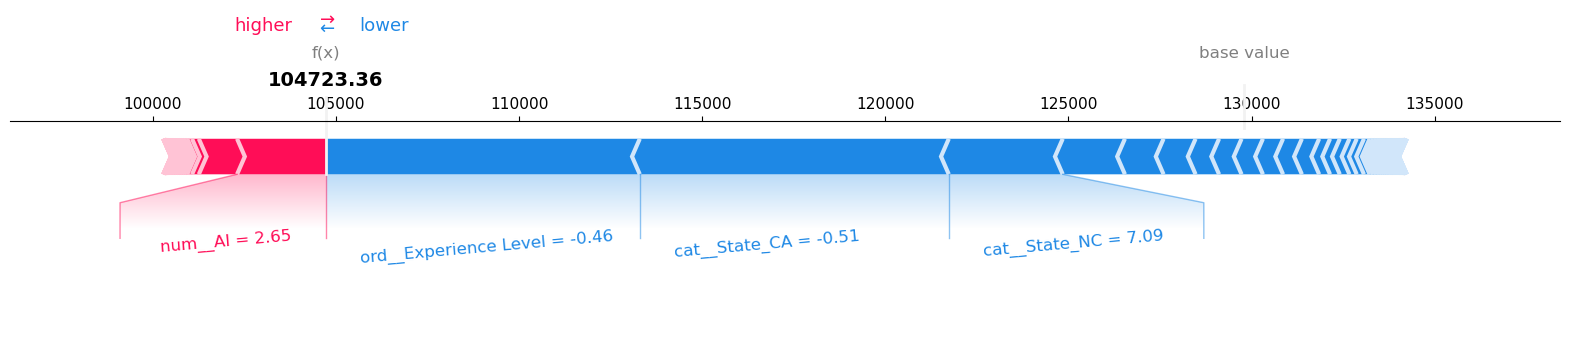

Force plot for data point at index 1:


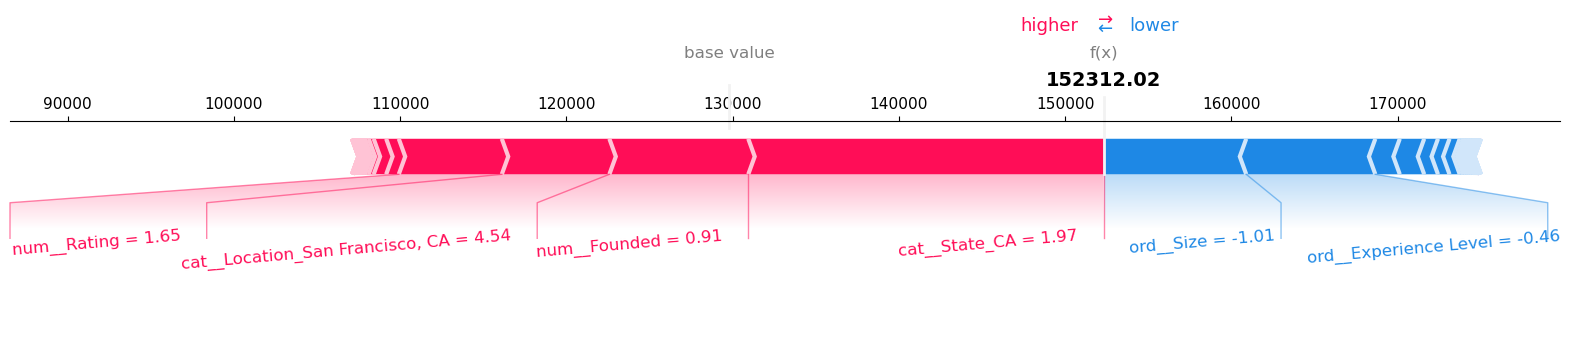

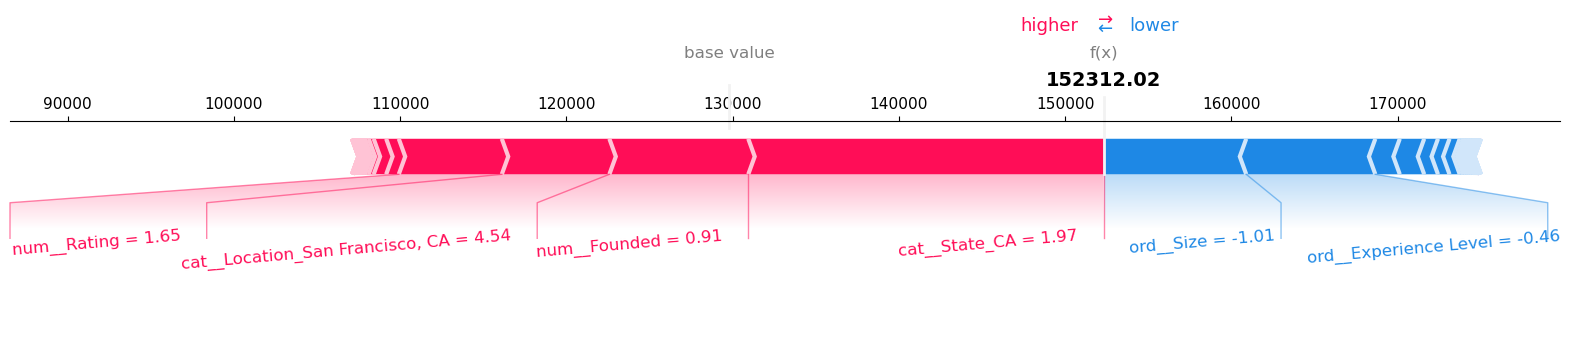

Force plot for data point at index 2:


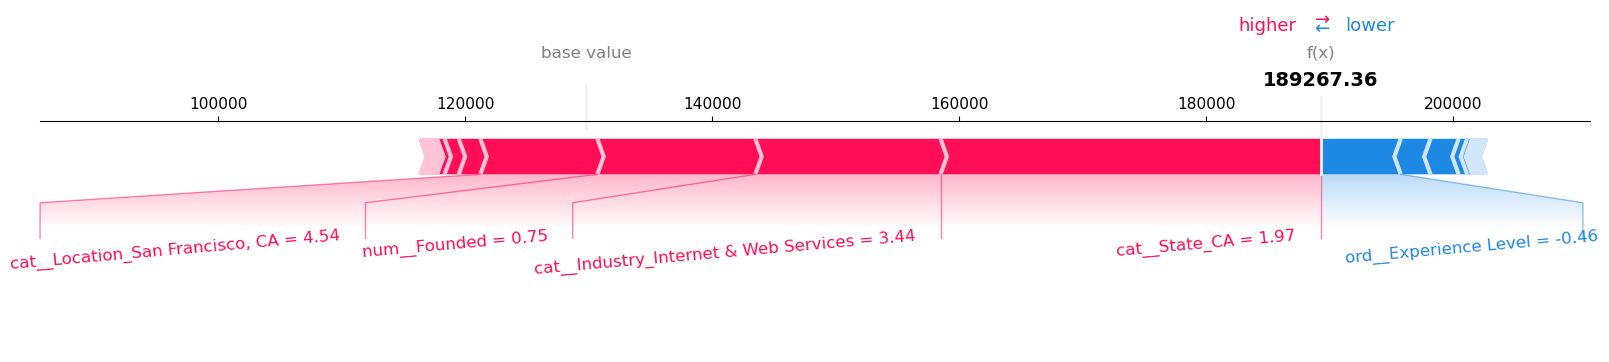

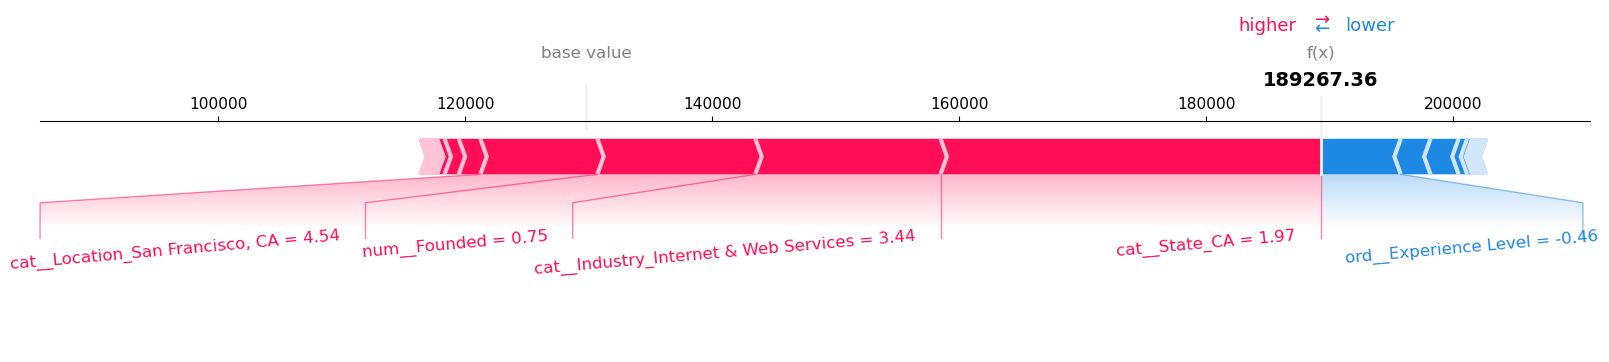

working on unique pattern 1
[{'max_depth': 1, 'max_features': 1.0}]
working on unique pattern 2
[{'max_depth': 1, 'max_features': 1.0}]
X_train shape: (405, 15)
X_CV shape: (131, 15)
X_test shape: (142, 15)
there are 3 unique missing value patterns.
working on unique pattern 0
[{'max_depth': 3, 'max_features': 0.75}]
working on unique pattern 1
[{'max_depth': 10, 'max_features': 0.25}]
working on unique pattern 2
[{'max_depth': 3, 'max_features': 0.25}]
Average RMSE: 34933.45645768191
RMSE standard deviation: 729.3786016251761
Baseline RMSE: 38239.093688193854
Baseline RMSE standard deviation: 2534.3063324262002


In [ ]:
rf_mean, rf_std, _, _ = get_performance(rf_model, rf_params, importance=True)

X_train shape: (410, 15)
X_CV shape: (143, 15)
X_test shape: (125, 15)
there are 3 unique missing value patterns.
working on unique pattern 0
[{'n_neighbors': 5, 'weights': 'distance'}]


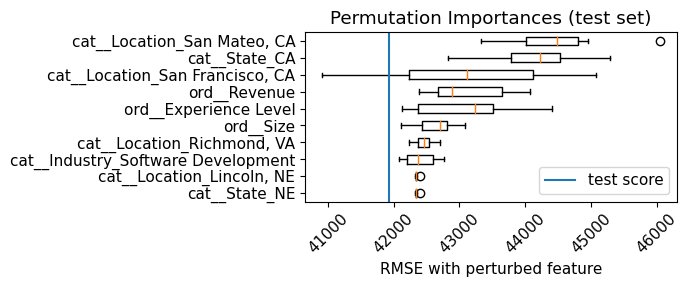

Permutation explainer: 108it [02:29,  1.51s/it]                         


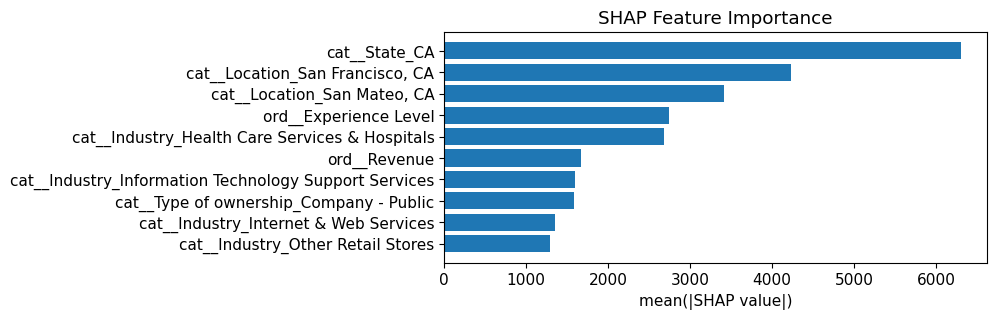

Force plot for data point at index 0:
Force plot for data point at index 1:
Force plot for data point at index 2:
working on unique pattern 1
[{'n_neighbors': 7, 'weights': 'uniform'}]
working on unique pattern 2
[{'n_neighbors': 13, 'weights': 'distance'}]
X_train shape: (405, 15)
X_CV shape: (131, 15)
X_test shape: (142, 15)
there are 3 unique missing value patterns.
working on unique pattern 0
[{'n_neighbors': 7, 'weights': 'uniform'}]
working on unique pattern 1
[{'n_neighbors': 7, 'weights': 'uniform'}]
working on unique pattern 2
[{'n_neighbors': 9, 'weights': 'uniform'}]
Average RMSE: 40808.40707727414
RMSE standard deviation: 1023.2554794905045
Baseline RMSE: 38239.093688193854
Baseline RMSE standard deviation: 2534.3063324262002


In [ ]:
knn_mean, knn_std, _, _ = get_performance(knn_model, knn_params, importance=True)

X_train shape: (410, 15)
X_CV shape: (143, 15)
X_test shape: (125, 15)
there are 3 unique missing value patterns.
working on unique pattern 0
[{'colsample_bytree': 0.9, 'learning_rate': 0.5, 'max_depth': 1, 'missing': nan, 'n_estimators': 10000, 'subsample': 0.66}]


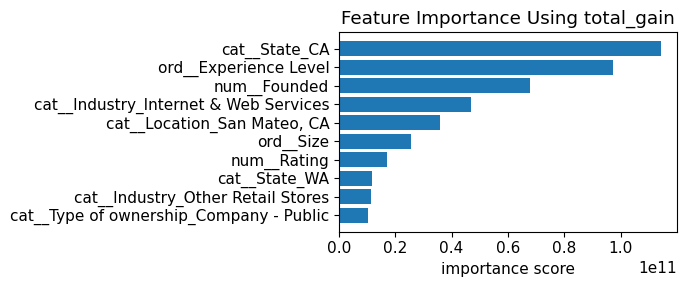

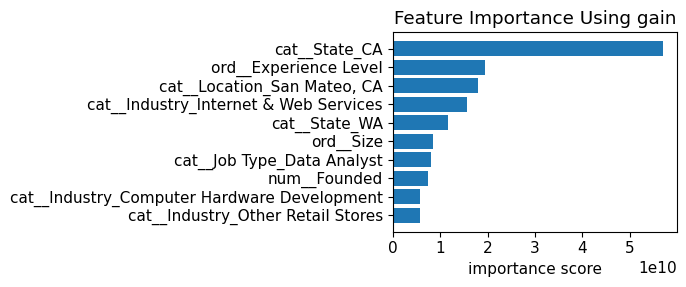

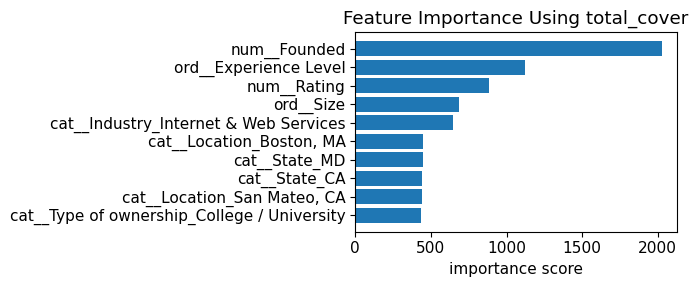

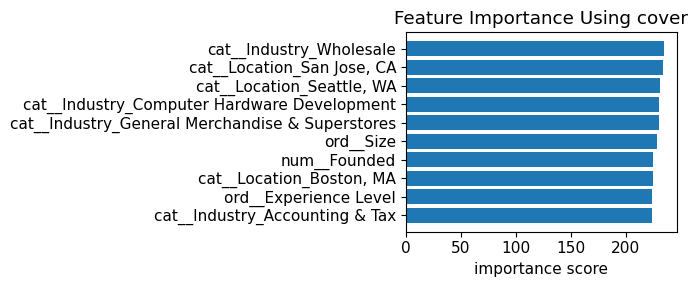

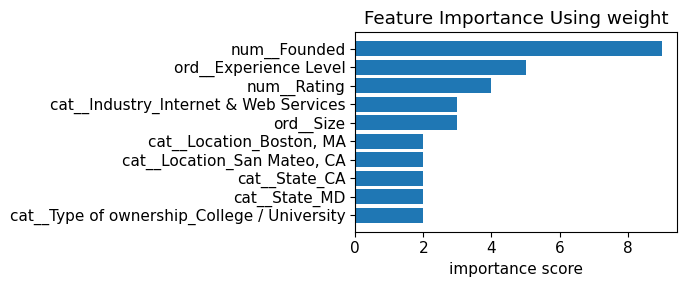

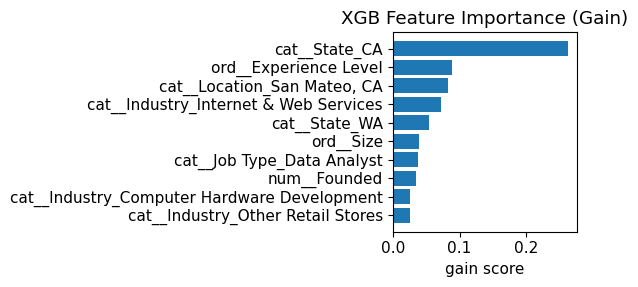

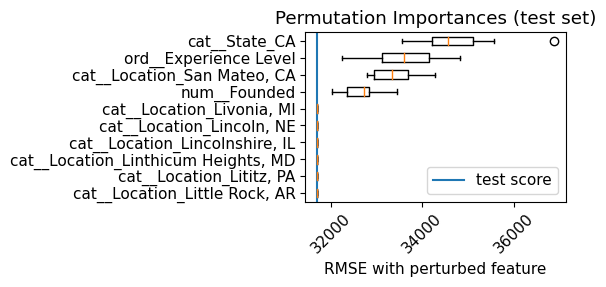

Permutation explainer: 108it [00:50,  1.75it/s]                         


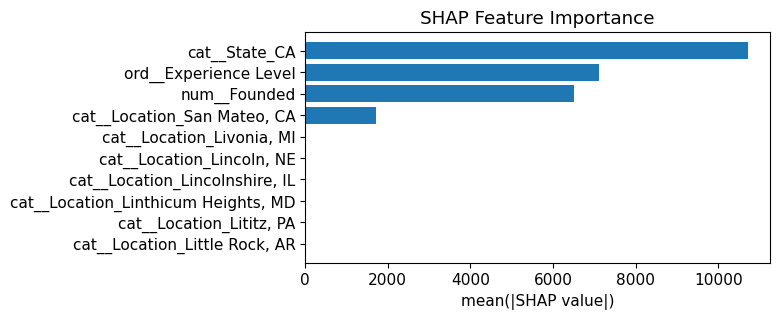

Force plot for data point at index 0:


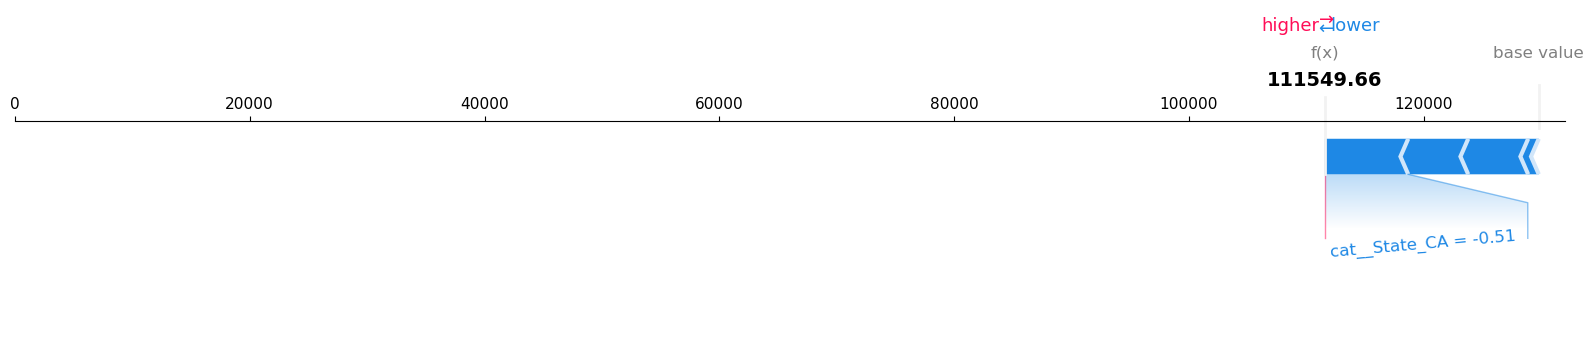

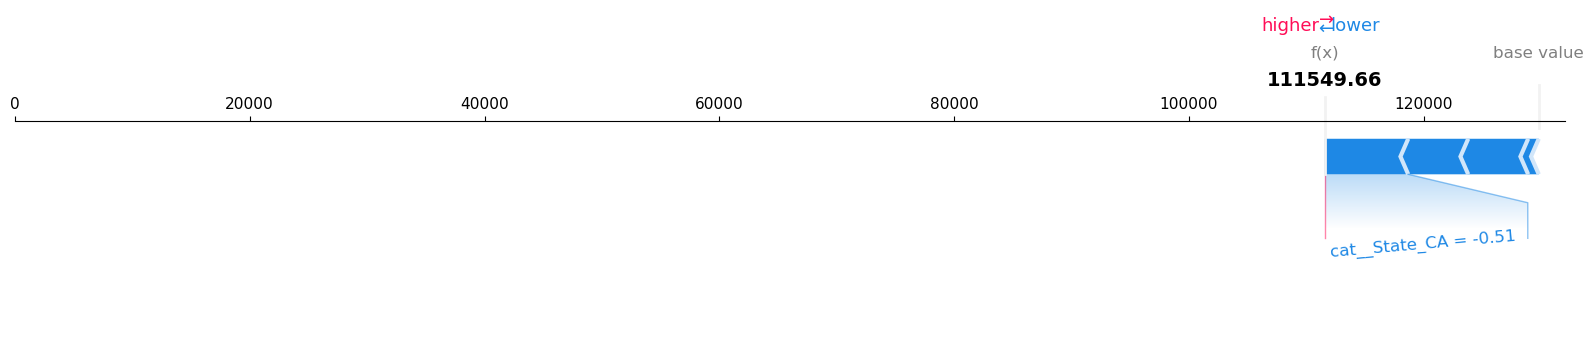

Force plot for data point at index 1:


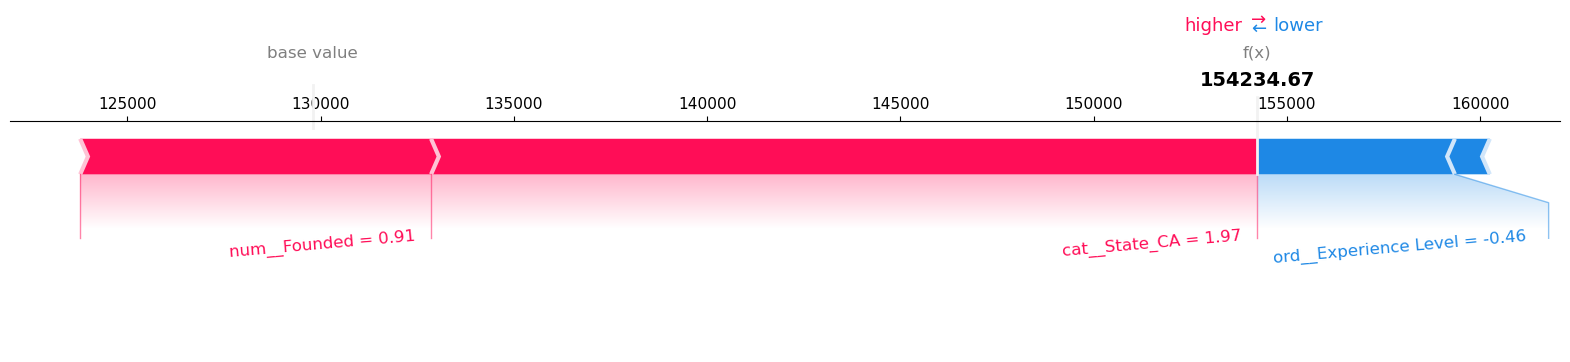

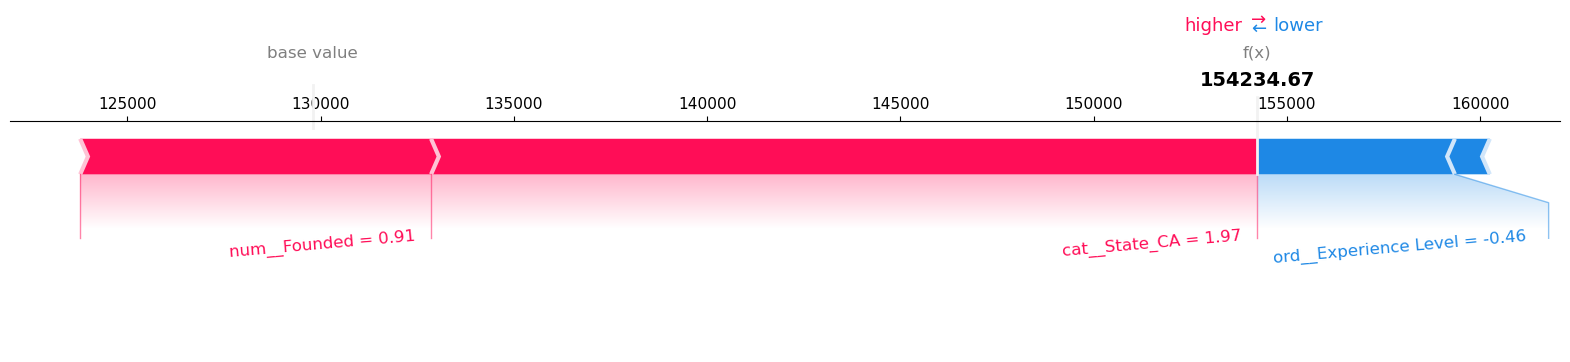

Force plot for data point at index 2:


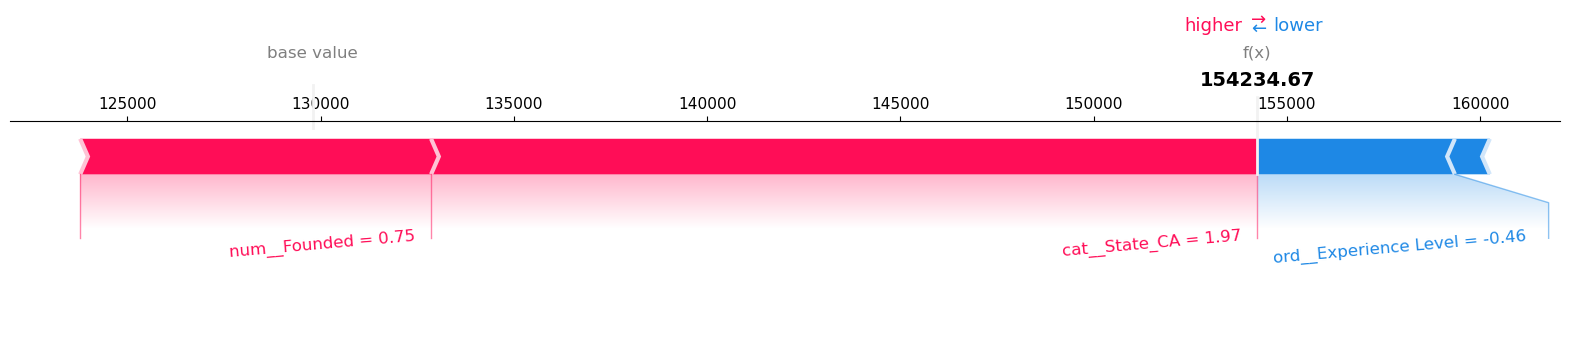

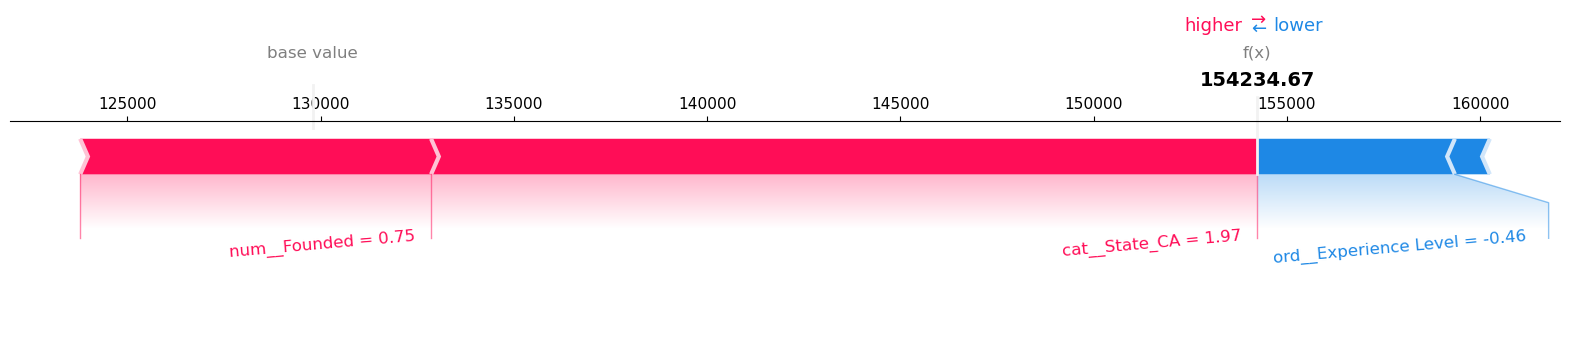

working on unique pattern 1
[{'colsample_bytree': 0.9, 'learning_rate': 0.5, 'max_depth': 1, 'missing': nan, 'n_estimators': 10000, 'subsample': 0.66}]
working on unique pattern 2
[{'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 1, 'missing': nan, 'n_estimators': 10000, 'subsample': 0.66}]
X_train shape: (405, 15)
X_CV shape: (131, 15)
X_test shape: (142, 15)
there are 3 unique missing value patterns.
working on unique pattern 0
[{'colsample_bytree': 0.9, 'learning_rate': 0.5, 'max_depth': 2, 'missing': nan, 'n_estimators': 10000, 'subsample': 0.66}]
working on unique pattern 1
[{'colsample_bytree': 0.9, 'learning_rate': 1.0, 'max_depth': 2, 'missing': nan, 'n_estimators': 10000, 'subsample': 0.66}]
working on unique pattern 2
[{'colsample_bytree': 0.9, 'learning_rate': 0.5, 'max_depth': 3, 'missing': nan, 'n_estimators': 10000, 'subsample': 0.66}]
Average RMSE: 33770.11070300535
RMSE standard deviation: 1642.373854023108
Baseline RMSE: 38239.093688193854
Baseline RMSE st

In [ ]:
xgb_mod = xgboost.XGBRegressor(n_jobs=1)
xgb_mean, xgb_std, _, _ = get_performance(xgb_mod, xgb_params, importance=True)

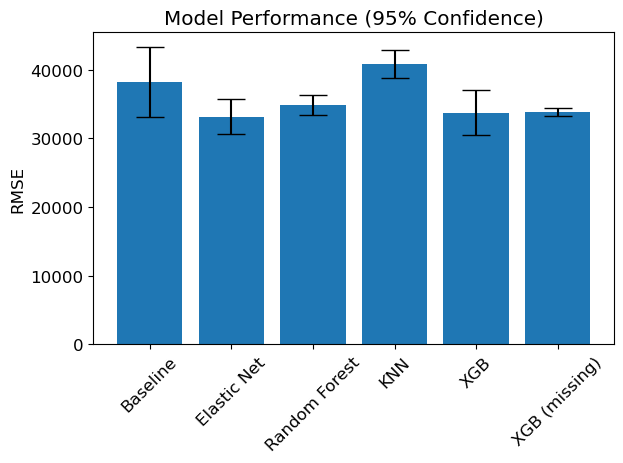

In [ ]:
import matplotlib.pyplot as plt

## Plot mean and std (95% confidence interval) for each model
#make sample data
# elastic_mean = 30000
# elastic_std = 2540
# rf_mean = 27000
# rf_std = 3600

means = np.array([baseline_rmse, elastic_mean, rf_mean, knn_mean, xgb_mean, xgb_missing_mean])
stds = np.array([baseline_std, elastic_std, rf_std, knn_std, xgb_std, xgb_missing_std])

plt.figsize=(10,8)
plt.rcParams.update({'font.size': 12})
plt.bar(['Baseline', 'Elastic Net', 'Random Forest', 'KNN', 'XGB', 'XGB (missing)'], means, yerr=2*stds, capsize=10)
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.title('Model Performance (95% Confidence)')
plt.tight_layout()
plt.savefig('figures/model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# import matplotlib.pyplot as plt
# plt.figure(figsize=(5,3))
# plt.errorbar(X.columns, np.mean(ws, axis=0), yerr=np.std(ws, axis=0), fmt='o', alpha=0.7, ecolor='black', capsize=5)
# plt.xlabel('feature')
# plt.ylabel('coefficient')
# plt.xticks(rotation=45)
# plt.title('Mean and Standard Deviation of Feature Coefficients')
# plt.show()

In [ ]:
print([np.around(num, 0) for num in means])
print([np.around(num, 0) for num in stds])
print([np.around(num - means[0], 0) for num in means])
print([np.around((num - means[0])/stds[0], 2) for num in means])

[39679.0, 34924.0, 34060.0, 39866.0, 33242.0, 34303.0]
[3546.0, 2548.0, 2265.0, 2243.0, 2380.0, 1910.0]
[0.0, -4755.0, -5619.0, 187.0, -6437.0, -5376.0]
[0.0, -1.34, -1.58, 0.05, -1.82, -1.52]
